<a href="https://colab.research.google.com/github/moisesmember/srag-covid-19/blob/main/SRAG_COVID_19_AM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<strong>TÍTULO: SIVEP GRIPE DATASUS – ANÁLISE E CLASSIFICAÇÃO DAS INTERNAÇÕES EM UTI POR COVID-19 NO ESTADO DO AMAZONAS</strong>
</br>
<strong>Fonte de dados disponível no link:</strong> <a href="https://drive.google.com/drive/folders/1Xqy813sSuIlcVlaJTLY_crgFACxYfNMX?usp=sharing">Clique aqui</a>
</br>
<strong>ALUNO: Moisés Felipe dos Santos</strong>


#Importação de Bibliotecas

In [ ]:
!pip install scikit-plot
!pip install imblearn --user
!pip install -U scikit-learn --user
!pip install imbalanced-learn
!pip install seaborn
!pip install folium==0.8.2
!pip install plotly --upgrade

In [ ]:
import pandas as pd
import csv
import math
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import folium
import pickle
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap
from google.colab import drive
from prettytable import PrettyTable
from matplotlib.text import Text
from matplotlib.legend_handler import HandlerBase
from datetime import datetime
from sklearn.model_selection import StratifiedShuffleSplit # Biblioteca de Machine Learning

import scikitplot as skplt
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

sns.set_theme(style="darkgrid") # Eu configuro os gráficos para exibirem em GRID cinza
drive.mount('/content/drive')

Mounted at /content/drive


<p>
SRAG 2020 - Banco de Dados de Síndrome Respiratória Aguda Grave - incluindo dados da COVID-19
Vigilância de Síndrome Respiratória Aguda Grave (SRAG)
O Ministério da Saúde (MS), por meio da Secretaria de Vigilância em Saúde (SVS), desenvolve a vigilância da Síndrome Respiratória Aguda Grave (SRAG) no Brasil, desde a pandemia de Influenza A(H1N1)pdm09 em 2009. A partir disso, esta vigilância foi implantada na rede de Influenza e outros vírus respiratórios, que anteriormente atuava apenas com a vigilância sentinela de Síndrome Gripal (SG).

Recentemente (2020), a vigilância da COVID-19, a infecção humana causada pelo novo Coronavírus, foi incorporada na rede de vigilância da Influenza e outros vírus respiratórios.

Esta página tem como finalidade disponibilizar o legado dos bancos de dados (BD) epidemiológicos de SRAG, da rede de vigilância da Influenza e outros vírus respiratórios, desde o início da sua implantação (2009) até os dias atuais (2020), com a incorporação da vigilância da COVID-19. Atualmente, o sistema oficial para o registro dos casos e óbitos de SRAG é o Sistema de Informação da Vigilância Epidemiológica da Gripe (SIVEP-Gripe).

No Guia de Vigilância Epidemiológica Emergência de Saúde Pública de Importância Nacional pela Doença pelo Coronavírus 2019 estão disponíveis informações sobre definições de casos, critérios de confirmação e encerramento dos casos, dentre outros.

Ressaltamos que os dados da vigilância de SRAG no Brasil disponibilizados nesta página, estão sujeitos a alterações decorrentes da investigação pelas equipes de vigilância epidemiológica que desenvolvem o serviço nas três esferas de gestão.

As bases de dados de SRAG disponibilizadas neste portal passam por tratamento que envolve a anonimização, em cumprimento a legislação.

Os dados de 2020 são disponibilizados semanalmente, às quartas-feiras, podendo, excepcionalmente, a atualização ocorrer em outro dia
</p>

#I - Coleta de Dados

###1.1 - Carregamento dos Dados

In [ ]:
chunks_srag_2020 = []
for chunk in pd.read_csv('/content/drive/MyDrive/TCC PUC MINAS - MOISES FELIPE DOS SANTOS/DATASET/SRAG_2020.csv', sep=';', low_memory=False, chunksize=2000):
    chunks_srag_2020.append(chunk) # Adiciono partições do DataSet no List
    
srag_2020 = pd.concat(chunks_srag_2020) # Uno todas as partições, então forma-se o Dataframe
chunks_srag_2020.clear() # Limpa List

chunks_srag_2021 = []
for chunk in pd.read_csv('/content/drive/MyDrive/TCC PUC MINAS - MOISES FELIPE DOS SANTOS/DATASET/SRAG_2021.csv', sep=';', low_memory=False, chunksize=2000):
    chunks_srag_2021.append(chunk) # Adiciono partições do DataSet no List
    
srag_2021 = pd.concat(chunks_srag_2021) # Uno todas as partições, então forma-se o Dataframe
chunks_srag_2021.clear() # Limpa List

# ---------------------- LOCALIZAÇÃO ----------------------------
cidades = pd.read_csv('/content/drive/MyDrive/TCC PUC MINAS - MOISES FELIPE DOS SANTOS/DATASET/ENDERECO/municipios.csv')
estados = pd.read_csv('/content/drive/MyDrive/TCC PUC MINAS - MOISES FELIPE DOS SANTOS/DATASET/ENDERECO/estados.csv')

# ---------------------- LEITOS SUS NO AMAZONAS --------------------
leitos_am = pd.read_csv('/content/drive/MyDrive/TCC PUC MINAS - MOISES FELIPE DOS SANTOS/DATASET/CNES_LEITOS_SUS.csv')

# ---------------------- INTERNAÇÕES NO AMAZONAS EM RELAÇÃO AOS LEITOS --------------------
internacao_leito_am = pd.read_csv('/content/drive/MyDrive/TCC PUC MINAS - MOISES FELIPE DOS SANTOS/DATASET/INTERNACAO_DIARIA_AMAZONAS.csv')

###1.2 - Seleciona as colunas para análise

In [ ]:
srag2020 = srag_2020[['DT_SIN_PRI','SG_UF_NOT','ID_MUNICIP','ID_UNIDADE','CS_SEXO','DT_NASC',
                      'CS_RACA','CS_ESCOL_N','CS_ZONA','SURTO_SG','FEBRE','TOSSE','GARGANTA',
                      'DISPNEIA','DESC_RESP','SATURACAO','DIARREIA','VOMITO','DOR_ABD','FADIGA',
                      'PERD_OLFT','PERD_PALA','OUTRO_SIN','FATOR_RISC','PUERPERA','CARDIOPATI',
                      'HEMATOLOGI','SIND_DOWN','HEPATICA','ASMA','DIABETES','NEUROLOGIC','PNEUMOPATI',
                      'IMUNODEPRE','RENAL','OBESIDADE','OUT_MORBI','VACINA','ANTIVIRAL','UTI',
                      'SUPORT_VEN','CLASSI_FIN']]

srag2021 = srag_2021[['DT_SIN_PRI','SG_UF_NOT','ID_MUNICIP','ID_UNIDADE','CS_SEXO','DT_NASC',
                      'CS_RACA','CS_ESCOL_N','CS_ZONA','SURTO_SG','FEBRE','TOSSE','GARGANTA',
                      'DISPNEIA','DESC_RESP','SATURACAO','DIARREIA','VOMITO','DOR_ABD',
                      'FADIGA','PERD_OLFT','PERD_PALA','OUTRO_SIN','FATOR_RISC','PUERPERA',
                      'CARDIOPATI','HEMATOLOGI','SIND_DOWN','HEPATICA','ASMA','DIABETES',
                      'NEUROLOGIC','PNEUMOPATI','IMUNODEPRE','RENAL','OBESIDADE','OUT_MORBI','VACINA',
                      'ANTIVIRAL','UTI','SUPORT_VEN','CLASSI_FIN']]

del srag_2020 # Excluir datasets primários da memória
del srag_2021 # Excluir datasets primários da memória

frames = [srag2020, srag2021] 
srag_geral = pd.concat(frames) # Concatenação de Dataframes

del srag2020 # Excluir datasets derivados da memória
del srag2021 # Excluir datasets derivados da memória

srag = srag_geral[srag_geral.CLASSI_FIN.isin([5])] # Filtra a CLASSIFICAÇÃO FINAL: SRAG POR COVID-19

del srag_geral

#II - Processamento/Tratamento de Dados

##2.1 - Tratando Dados

###2.1.1 - SRAG

In [ ]:
print(srag.info())
print('================================================================')
print(internacao_leito_am.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1447274 entries, 7 to 1085026
Data columns (total 42 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   DT_SIN_PRI  1447274 non-null  object 
 1   SG_UF_NOT   1447274 non-null  object 
 2   ID_MUNICIP  1447274 non-null  object 
 3   ID_UNIDADE  1447274 non-null  object 
 4   CS_SEXO     1447274 non-null  object 
 5   DT_NASC     1445641 non-null  object 
 6   CS_RACA     1414652 non-null  float64
 7   CS_ESCOL_N  968900 non-null   float64
 8   CS_ZONA     1286978 non-null  float64
 9   SURTO_SG    694811 non-null   float64
 10  FEBRE       1232850 non-null  float64
 11  TOSSE       1270929 non-null  float64
 12  GARGANTA    1042690 non-null  float64
 13  DISPNEIA    1280413 non-null  float64
 14  DESC_RESP   1184271 non-null  float64
 15  SATURACAO   1226255 non-null  float64
 16  DIARREIA    1026674 non-null  float64
 17  VOMITO      1005294 non-null  float64
 18  DOR_ABD     807276 non

###3 - Eliminando valores nulos

In [ ]:
# Conversão de tipo da DATA PRIMEIROS SINTOMAS
srag['DT_NASC'] =  pd.to_datetime(srag['DT_NASC'], format='%d/%m/%Y')
srag['DT_SIN_PRI'] = pd.to_datetime(srag['DT_SIN_PRI'], format='%d/%m/%Y')

now = pd.to_datetime(datetime.today().strftime('%Y-%m-%d')) # PEGA A DATA ATUAL
srag['IDADE'] = now.year - srag['DT_NASC'].dt.year # REALIZA A DIFERENÇA PARA GERAR A IDADE
srag = srag.fillna({'IDADE': int(np.mean(srag.IDADE))}) # NAS IDADES NULAS SE ATRIBUI A MÉDIA DAS IDADE

srag = srag.fillna({'SUPORT_VEN': 9})

# Substitui as colunas vazias por um valor default
srag.CS_RACA = srag.CS_RACA.fillna(9)  # Raça/Cor - 9-Ignorado
srag.CS_SEXO = srag.CS_SEXO.fillna('I')  # Sexo - I-Ignorado
srag.CS_ESCOL_N = srag.CS_ESCOL_N.fillna(9) # Escolaridade - 9-Ignorado
srag.CS_ZONA = srag.CS_ZONA.fillna(9) # Zona residência - 9-Ignorado
srag.SURTO_SG = srag.SURTO_SG.fillna(9) # Caso é proveniente de surto de SG? - 9-Ignorado

srag.FEBRE = srag.FEBRE.fillna(9) #  9-Ignorado
srag.TOSSE = srag.TOSSE.fillna(9) # 9-Ignorado
srag.GARGANTA = srag.GARGANTA.fillna(9) # 9-Ignorado
srag.DISPNEIA = srag.DISPNEIA.fillna(9) # 9-Ignorado
srag.DESC_RESP = srag.DESC_RESP.fillna(9) # 9-Ignorado
srag.SATURACAO = srag.SATURACAO.fillna(9) # 9-Ignorado
srag.DIARREIA = srag.DIARREIA.fillna(9) # 9-Ignorado
srag.VOMITO = srag.VOMITO.fillna(9) # 9-Ignorado
srag.DOR_ABD = srag.DOR_ABD.fillna(9) # 9-Ignorado
srag.FADIGA = srag.FADIGA.fillna(9) # 9-Ignorado
srag.PERD_OLFT = srag.PERD_OLFT.fillna(9) # 9-Ignorado
srag.PERD_PALA = srag.PERD_PALA.fillna(9) # 9-Ignorado
srag.OUTRO_SIN = srag.OUTRO_SIN.fillna(9) # 9-Ignorado
srag.FATOR_RISC = srag.FATOR_RISC.fillna(9) # 9-Ignorado
srag.PUERPERA = srag.PUERPERA.fillna(9) # 9-Ignorado
srag.CARDIOPATI = srag.CARDIOPATI.fillna(9) # 9-Ignorado
srag.HEMATOLOGI = srag.HEMATOLOGI.fillna(9) # 9-Ignorado
srag.SIND_DOWN = srag.SIND_DOWN.fillna(9) # 9-Ignorado
srag.HEPATICA = srag.HEPATICA.fillna(9) # 9-Ignorado
srag.ASMA = srag.ASMA.fillna(9) # 9-Ignorado
srag.DIABETES	= srag.DIABETES	.fillna(9) # 9-Ignorado
srag.NEUROLOGIC = srag.NEUROLOGIC.fillna(9) # 9-Ignorado
srag.PNEUMOPATI = srag.PNEUMOPATI.fillna(9) # 9-Ignorado
srag.IMUNODEPRE = srag.IMUNODEPRE.fillna(9) # 9-Ignorado
srag.RENAL	= srag.RENAL.fillna(9) # 9-Ignorado
srag.OBESIDADE = srag.OBESIDADE.fillna(9) # 9-Ignorado
srag.OUT_MORBI = srag.OUT_MORBI.fillna(9) # 9-Ignorado
srag.VACINA = srag.VACINA.fillna(9) # 9-Ignorado
srag.ANTIVIRAL = srag.ANTIVIRAL.fillna(9) # 9-Ignorado
srag.UTI = srag.UTI.fillna(9) # Caso de SRAG com infecção adquirida após internação. - 9-Ignorado
srag.CLASSI_FIN = srag.CLASSI_FIN.fillna(9)

srag.loc[srag.FATOR_RISC == 1, 'FATOR_RISC'] = 'S'
srag.loc[srag.FATOR_RISC == 2, 'FATOR_RISC'] = 'N'

# ATRIBUIÇÃO DE RÓTULO A FAIXA ETÁRIA
srag.loc[srag.IDADE < 60, 'FAIXA_ETARIA' ] = '< 60'
srag.loc[srag.IDADE >= 60, 'FAIXA_ETARIA' ] = '>= 60'

# Filtra apenas a CLASSIFICAÇÃO FINAL: SRAG POR COVID-19 do estado do AMAZONAS
srag = srag[(srag.UTI != 9) & (srag.SG_UF_NOT == 'AM')]

print('COM DADOS DUPLICADOS')
print(srag.shape)

# REMOVE DADOS DUPLICADOS
srag.duplicated() # Verifica se tem dados duplicados
srag = srag.drop_duplicates() # Remove possíveis dados duplicados

print('SEM DADOS DUPLICADOS')
print(srag.shape)

COM DADOS DUPLICADOS
(28010, 44)
SEM DADOS DUPLICADOS
(28006, 44)


#III - Análise e Exploração dos Dados

##3.1 - Origens dos Dados


In [ ]:
print('=======================================================================')
unidade_saudes = srag.groupby(['ID_UNIDADE']).size().reset_index(name='num_casos_reportado')
print('Nº Unidades de Saúde reportadoras: {:.0f}'.format(unidade_saudes['ID_UNIDADE'].count()))
print('=======================================================================')
print('#####\t\tESTADOS REPORTADORES DE CASOS\t\t#####')
estado_reporta = srag.groupby(['SG_UF_NOT']).size().reset_index(name='num_casos_reportado')
estado_reporta.sort_values(by='num_casos_reportado',ascending = False)

Nº Unidades de Saúde reportadoras: 126
#####		ESTADOS REPORTADORES DE CASOS		#####


,SG_UF_NOT,num_casos_reportado
0,AM,28006


##3.2 - Mapa de Calor de Notificações de COVID-19 no Brasil

In [ ]:
cidades_estado = pd.merge(estados, cidades, left_on='codigo_uf', right_on='codigo_uf', suffixes=('_state', '_city'))
notificacoes_em_municipios = pd.merge(estado_reporta, cidades_estado, left_on='SG_UF_NOT', right_on='uf', suffixes=('_uf', '_uf_coordernadas'))

lat = notificacoes_em_municipios.latitude_city.tolist()
lng = notificacoes_em_municipios.longitude_city.tolist()
mapa_brasil = folium.Map(
    location=[-3.10719, -60.0261],
    zoom_start=5
)
HeatMap(list(zip(lat, lng))).add_to(mapa_brasil)
mapa_brasil

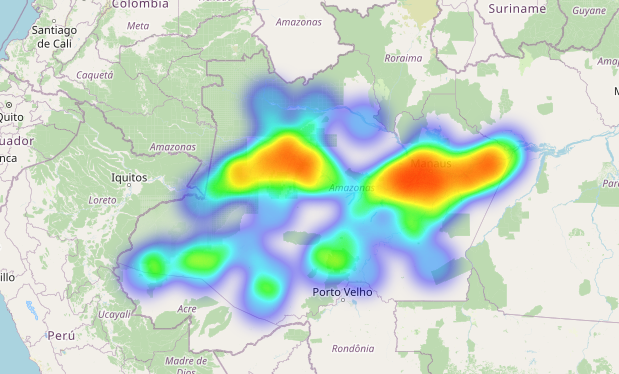

##3.3 - Análise temporal mês/semana por Data Notificação

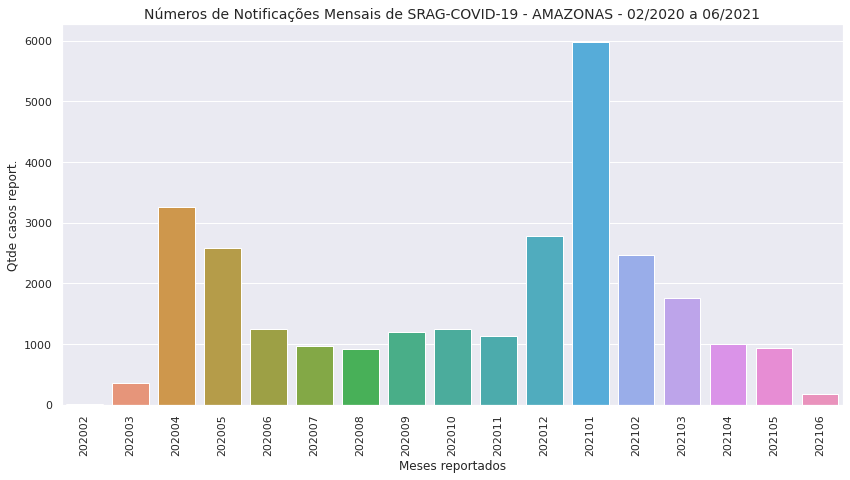

In [ ]:
### NÚMERO MENSAL DE CASOS COVID
srag['DATA_MES_ANO'] = srag['DT_SIN_PRI'].map(lambda x: 100*x.year + x.month) # adição de nova coluna com o MÊS e ANO data DATA SINTOMAS
#junto pelo mes_ano igual somando a quantidade_itens
num_casos_mensais = srag.groupby(['DATA_MES_ANO']).size().reset_index(name='counts')

# GRÁFICO BARRA - CASOS MENSAIS REPORTADOS 
plt.figure(figsize=(14,7))
bar_plot_mensal_report = sns.countplot(x="DATA_MES_ANO",data=srag)
plt.title('Números de Notificações Mensais de SRAG-COVID-19 - AMAZONAS - 02/2020 a 06/2021',fontsize=14)
bar_plot_mensal_report.set_xticklabels(bar_plot_mensal_report.get_xticklabels(),rotation=90)
bar_plot_mensal_report.set(xlabel='Meses reportados', ylabel='Qtde casos report.')
plt.show();

Resumo das notificações
count      67.0
mean      418.0
std       344.1
min         1.0
25%       227.0
50%       279.0
75%       468.0
max      1672.0
Name: SUM, dtype: float64


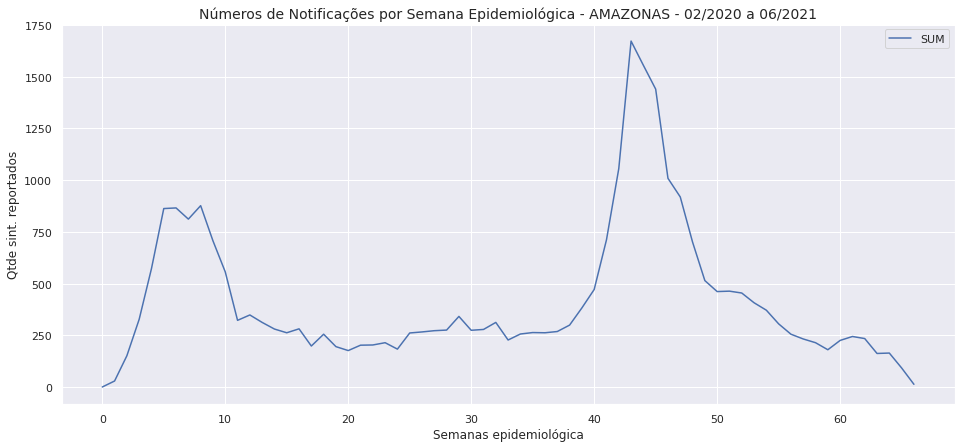

In [ ]:
# PARA GERAR O HISTOGRAMA, EU VOU SOMAR OS VALORES POR SEMANA
diaria_primeiro_sint = srag.groupby(['DT_SIN_PRI']).size().reset_index(name='counts')
diaria_primeiro_sint['SEMANA'] = diaria_primeiro_sint['DT_SIN_PRI'].dt.to_period('W-THU') # Adiciona a SEMANA
diaria_primeiro_sint_semana = diaria_primeiro_sint.groupby(['SEMANA'])['counts'].agg('sum').reset_index(name='SUM')
print('Resumo das notificações')
print(diaria_primeiro_sint_semana['SUM'].describe().round(1))

# EXIBE A EVOLUÇÃO DOS CASOS EM RELAÇÃO AS SEMANAS OBSERVADAS
plt.figure(figsize=(16,7))
line_semanas_pac = sns.lineplot(err_style='bars', data = diaria_primeiro_sint_semana)
plt.title('Números de Notificações por Semana Epidemiológica - AMAZONAS - 02/2020 a 06/2021',fontsize=14)
line_semanas_pac.set(xlabel='Semanas epidemiológica', ylabel='Qtde sint. reportados')
plt.show()

Valor mínimo: 1
Valor máximo: 1672
Média: 418
Mediana: 279
Moda: ModeResult(mode=array([215]), count=array([2]))
Curva enviesado a direita, pois a MEDIANA é MAIOR que a MÉDIA




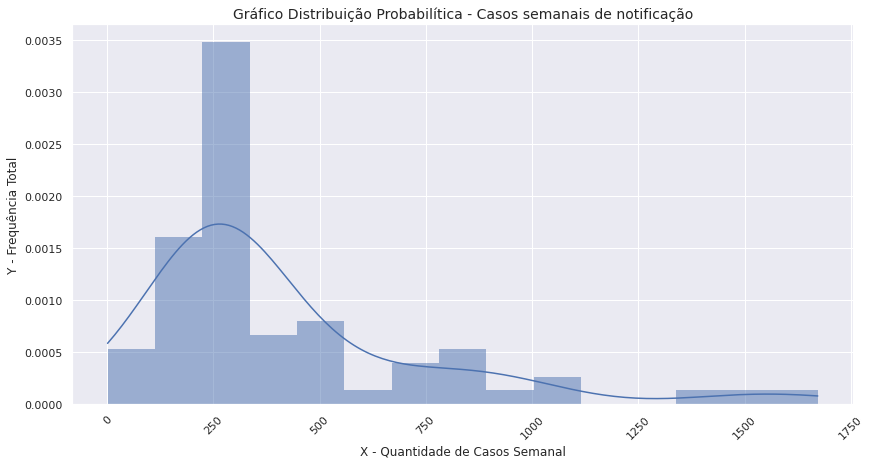

In [ ]:
distribuicao_casos_semanal = np.sort(diaria_primeiro_sint_semana.SUM) # Ordena valores
distribuicao_casos_semanal = distribuicao_casos_semanal[~np.isnan(distribuicao_casos_semanal)] # Exclusão de valores NaN

print('Valor mínimo: {:.0f}'.format(distribuicao_casos_semanal.min()))
print('Valor máximo: {:.0f}'.format(distribuicao_casos_semanal.max()))
print('Média: {:.0f}'.format(distribuicao_casos_semanal.mean()))
print('Mediana: {:.0f}'.format(np.median(distribuicao_casos_semanal)))
print('Moda: '+str(stats.mode(distribuicao_casos_semanal)))
print('Curva enviesado a direita, pois a MEDIANA é MAIOR que a MÉDIA')
print('\n')

plt.figure(figsize=(14,7))
sns.histplot(distribuicao_casos_semanal, kde=True, stat="density", linewidth=0);
plt.title('Gráfico Distribuição Probabilítica - Casos semanais de notificação', fontsize=14);
plt.xlabel('X - Quantidade de Casos Semanal') # fontsize=14
plt.ylabel('Y - Frequência Total')
plt.xticks(rotation=45)
plt.show();

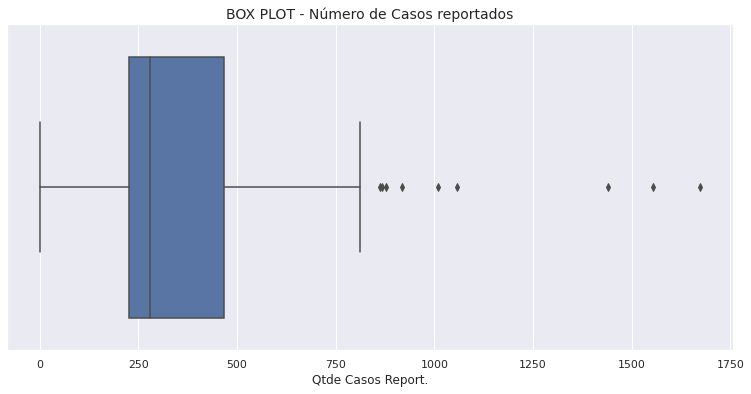

In [ ]:
# Usa a biblioteca SEABORN
# BoxPlot de pacientes semanal
plt.figure(figsize=(13,6))
boxplotSemanal = sns.boxplot(x=diaria_primeiro_sint_semana['SUM'])
plt.title('BOX PLOT - Número de Casos reportados',fontsize=14)
boxplotSemanal.set(xlabel='Qtde Casos Report.')
plt.show()

##3.4 - Internações por COVID-19 no Amazonas

###I - Histórico de Internações em UTI por Data de Notificação

Resumo das Internações no Amazonas
count     66.0
mean      99.7
std       83.9
min        2.0
25%       46.2
50%       67.0
75%      127.8
max      450.0
Name: SUM, dtype: float64


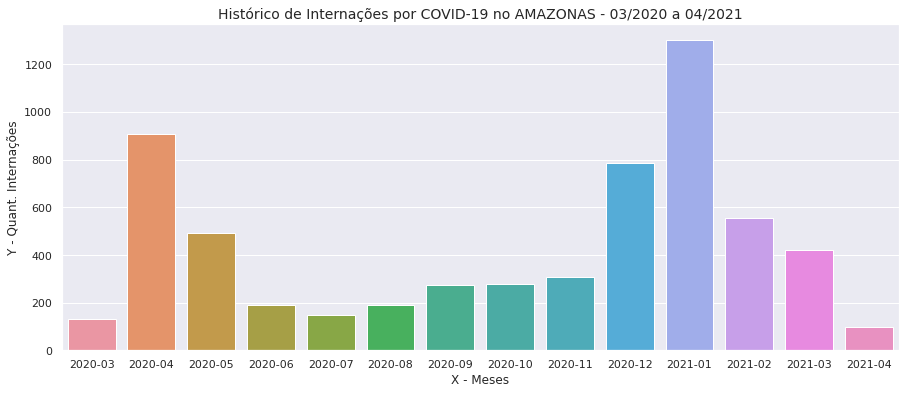

In [ ]:
qtde_temporal_internacao_uti = srag[srag.UTI.isin([1])] # Filtra da amostra apenas as Internações em UTI
qtde_temporal_pac_comorbidade = srag[srag.FATOR_RISC.isin(['S'])] # Filtra da amostra apenas as casos com pacientes COMORBIDADES

# PARA GERAR O HISTOGRAMA, EU VOU SOMAR OS VALORES POR SEMANA
diaria_primeiro_sint_inter_uti = qtde_temporal_internacao_uti.groupby(['DT_SIN_PRI']).size().reset_index(name='counts')
diaria_primeiro_sint_inter_uti['SEMANA_UTI'] = diaria_primeiro_sint_inter_uti['DT_SIN_PRI'].dt.to_period('W-THU') # Adiciona a SEMANA
#diaria_primeiro_sint.head(35)

#diaria_primeiro_sint_semana = diaria_primeiro_sint.groupby(['SEMANA']).sum() #.reset_index(name='sum')
diaria_primeiro_sint_semana_inter_uti = diaria_primeiro_sint_inter_uti.groupby(['SEMANA_UTI'])['counts'].agg('sum').reset_index(name='SUM')
print('Resumo das Internações no Amazonas')
print(diaria_primeiro_sint_semana_inter_uti['SUM'].describe().round(1))
plt.figure(figsize=(15,6))
ay = sns.barplot(x="mes_internacao", y="internacao_uti", data=internacao_leito_am.sort_values(['mes_internacao']))

plt.title('Histórico de Internações por COVID-19 no AMAZONAS - 03/2020 a 04/2021', fontsize=14);
plt.xlabel('X - Meses') # fontsize=14
plt.ylabel('Y - Quant. Internações')
plt.show(); 

###II - Leitos para COVDI-19 no Amazonas 

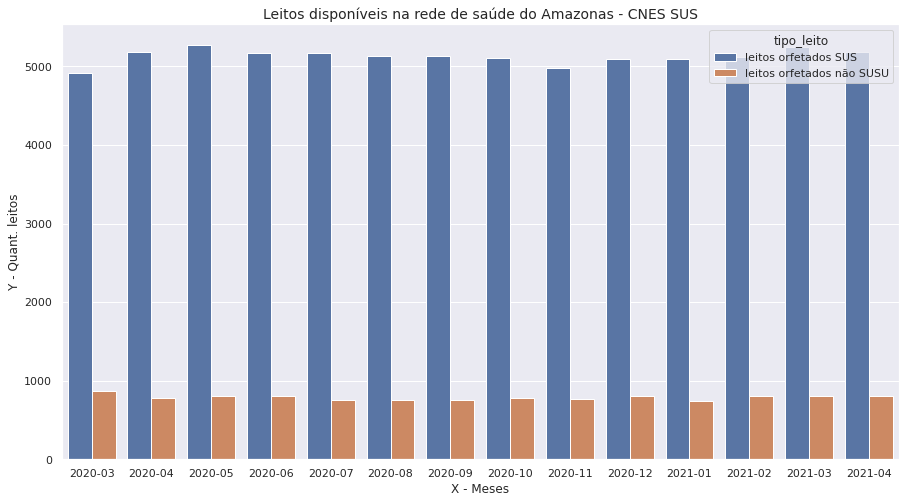

In [ ]:
mes                  = internacao_leito_am['mes_internacao']
leitos_covid_sus     = internacao_leito_am['leitos_covid_sus']
qtde_leito_sus       = internacao_leito_am['qtde_leito_sus']
leitos_covid_nao_sus = internacao_leito_am['leitos_covid_nao_sus']
qtde_leito_nao_sus   = internacao_leito_am['qtde_leito_nao_sus']

leitos_sus = pd.DataFrame({
                            'mes': mes,
                            'tipo_leito': leitos_covid_sus,
                            'qtde_leito': qtde_leito_sus
                          })

leitos_nao_sus = pd.DataFrame({
                            'mes': mes,
                            'tipo_leito': leitos_covid_nao_sus,
                            'qtde_leito': qtde_leito_nao_sus
                          })

frames = [leitos_sus, leitos_nao_sus] 
leitos_ofertados = pd.concat(frames) # Concatenação de Dataframes
del leitos_sus
del leitos_nao_sus
del frames

plt.figure(figsize=(15,8))
ax = sns.barplot(x="mes", y="qtde_leito",hue="tipo_leito", data=leitos_ofertados.sort_values(['mes']))

plt.title('Leitos disponíveis na rede de saúde do Amazonas - CNES SUS', fontsize=14);
plt.xlabel('X - Meses') # fontsize=14
plt.ylabel('Y - Quant. leitos')
plt.show();

###III - Análise Temporal de Pacientes com COMORBIDADES por Data de Notificação

Resumo do histórico de internação/comorbidade no Amazonas
       SUM_SEMANA_UTI  SUM_SEMANA_FATOR_RISC
count       66.000000               66.00000
mean        99.742424              213.80303
std         83.946927              178.54999
min          2.000000                8.00000
25%         46.250000              106.50000
50%         67.000000              148.50000
75%        127.750000              217.00000
max        450.000000              826.00000


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


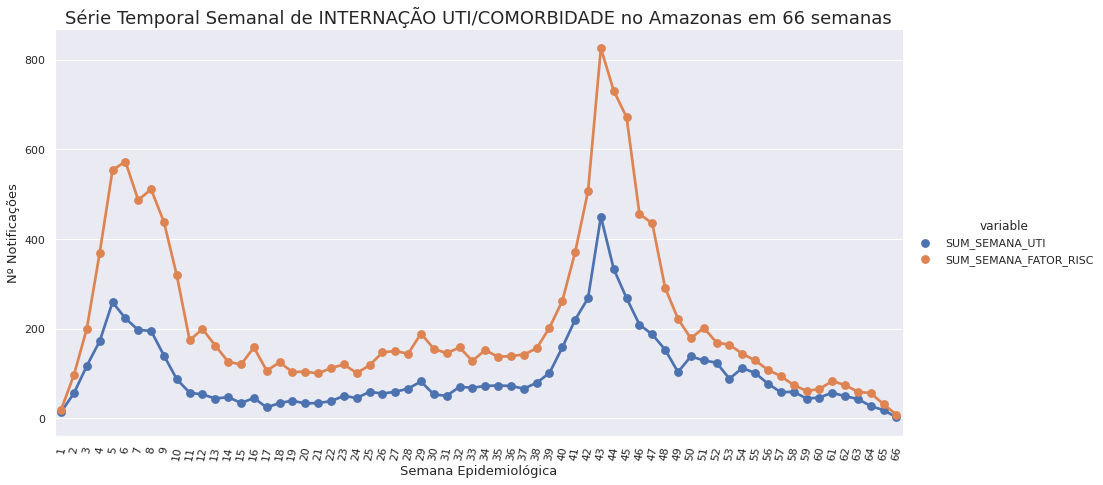

In [ ]:
# PARA GERAR O HISTOGRAMA, EU VOU SOMAR OS VALORES POR SEMANA
diaria_primeiro_sint_pac_comorbidade = qtde_temporal_pac_comorbidade.groupby(['DT_SIN_PRI']).size().reset_index(name='counts')
diaria_primeiro_sint_pac_comorbidade['SEMANA_FATOR_RISC'] = diaria_primeiro_sint_pac_comorbidade['DT_SIN_PRI'].dt.to_period('W-THU') # Adiciona a SEMANA
diaria_primeiro_sint_pac_comorbidade = diaria_primeiro_sint_pac_comorbidade.groupby(['SEMANA_FATOR_RISC'])['counts'].agg('sum').reset_index(name='SUM')
print('Resumo do histórico de internação/comorbidade no Amazonas')

# É realizado a união das duas Análises Temporais
analise_tempor_interna_comobirdade = pd.merge(diaria_primeiro_sint_semana_inter_uti, 
                                              diaria_primeiro_sint_pac_comorbidade, 
                                              left_on='SEMANA_UTI', right_on='SEMANA_FATOR_RISC',
                                                 suffixes=('_SEMANA_UTI', '_SEMANA_FATOR_RISC'))
analise_tempor_interna_comobirdade['ID'] = range(1, 1+len(analise_tempor_interna_comobirdade))

print(analise_tempor_interna_comobirdade.describe().iloc[:,[0,1]] )

analise_tempor_interna_comobirdade_formata = pd.melt(analise_tempor_interna_comobirdade, id_vars=['ID'], value_vars=['SUM_SEMANA_UTI','SUM_SEMANA_FATOR_RISC'])
plot_line_interna_comobirdade = sns.factorplot(x='ID', y="value", hue='variable', height=6.27, aspect=16.7/8.27, data=analise_tempor_interna_comobirdade_formata);

plt.title('Série Temporal Semanal de INTERNAÇÃO UTI/COMORBIDADE no Amazonas em 66 semanas', fontsize=18)
plt.xlabel('Semana Epidemiológica',fontsize=13) # fontsize=14
plt.ylabel('Nº Notificações',fontsize=13)
plt.xticks(rotation=80);

plt.show();

Valor mínimo: 2
Valor máximo: 450
Média: 100
Mediana: 67
Moda: ModeResult(mode=array([34]), count=array([3]))
Curva enviesado a direita, pois a MEDIANA é MAIOR que a MÉDIA




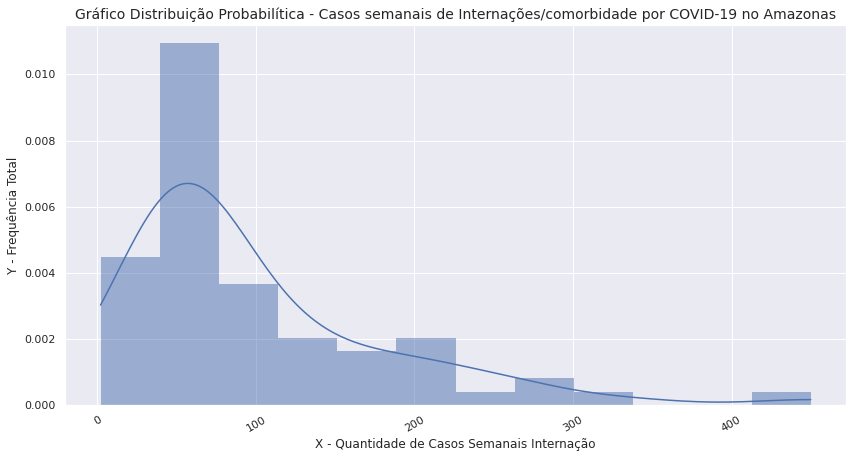

In [ ]:
num_semanal_interna_uti = np.sort(analise_tempor_interna_comobirdade['SUM_SEMANA_UTI']) # Ordena valores
num_semanal_fator_risco = np.sort(analise_tempor_interna_comobirdade['SUM_SEMANA_FATOR_RISC']) # Ordena valores

num_semanal_interna_uti = num_semanal_interna_uti[~np.isnan(num_semanal_interna_uti)] # Exclusão de valores NaN
num_semanal_fator_risco = num_semanal_fator_risco[~np.isnan(num_semanal_fator_risco)] # Exclusão de valores NaN

print('Valor mínimo: {:.0f}'.format(num_semanal_interna_uti.min()))
print('Valor máximo: {:.0f}'.format(num_semanal_interna_uti.max()))
print('Média: {:.0f}'.format(num_semanal_interna_uti.mean()))
print('Mediana: {:.0f}'.format(np.median(num_semanal_interna_uti)))
print('Moda: '+str(stats.mode(num_semanal_interna_uti)))
print('Curva enviesado a direita, pois a MEDIANA é MAIOR que a MÉDIA')
print('\n')

plt.figure(figsize=(14,7))
sns.histplot(num_semanal_interna_uti, kde=True, stat="density", linewidth=0);
plt.title('Gráfico Distribuição Probabilítica - Casos semanais de Internações/comorbidade por COVID-19 no Amazonas', fontsize=14);
plt.xlabel('X - Quantidade de Casos Semanais Internação') # fontsize=14
plt.ylabel('Y - Frequência Total')
plt.xticks(rotation=30)
plt.show();

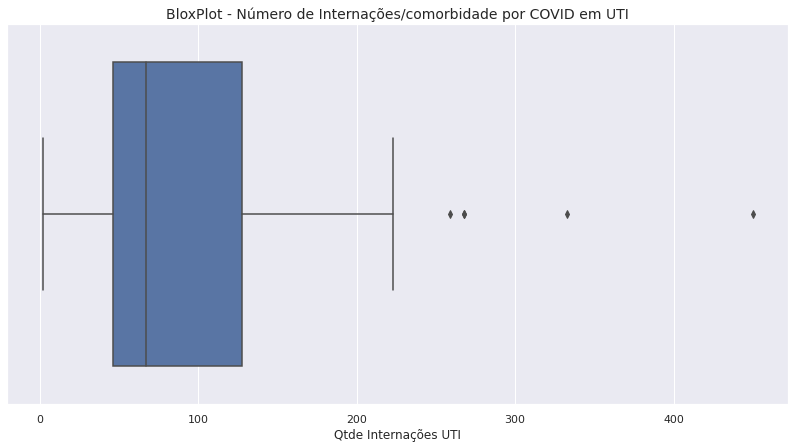

In [ ]:
# Usa a biblioteca SEABORN
# BoxPlot de pacientes semanal
plt.figure(figsize=(14,7))
boxplotSemanal_interna_uti = sns.boxplot(x=analise_tempor_interna_comobirdade['SUM_SEMANA_UTI'])
plt.title('BloxPlot - Número de Internações/comorbidade por COVID em UTI', fontsize=14)
boxplotSemanal_interna_uti.set(xlabel='Qtde Internações UTI')
plt.show()

###IV - Casos envolvendo pacientes com fator de risco

Valor mínimo: 8
Valor máximo: 826
Média: 214
Mediana: 148
Moda: ModeResult(mode=array([74]), count=array([2]))
Curva enviesado a direita, pois a MEDIANA é MAIOR que a MÉDIA




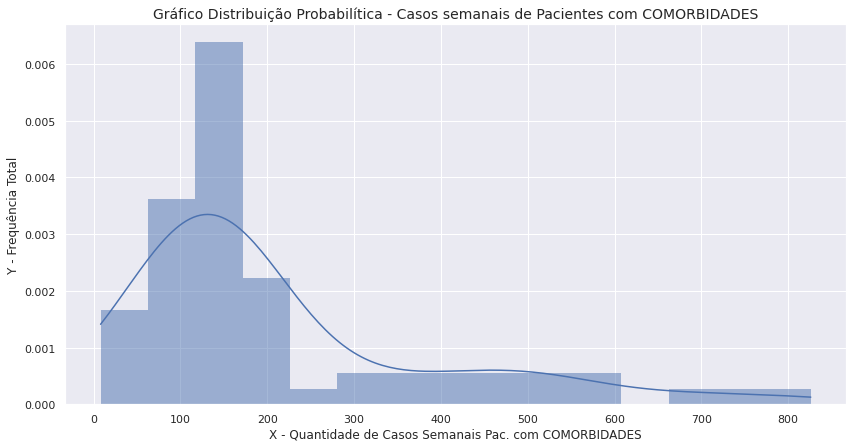

In [ ]:
print('Valor mínimo: {:.0f}'.format(num_semanal_fator_risco.min()))
print('Valor máximo: {:.0f}'.format(num_semanal_fator_risco.max()))
print('Média: {:.0f}'.format(num_semanal_fator_risco.mean()))
print('Mediana: {:.0f}'.format(np.median(num_semanal_fator_risco)))
print('Moda: '+str(stats.mode(num_semanal_fator_risco)))
print('Curva enviesado a direita, pois a MEDIANA é MAIOR que a MÉDIA')
print('\n')

plt.figure(figsize=(14,7))
sns.histplot(num_semanal_fator_risco, kde=True, stat="density", linewidth=0);
plt.title('Gráfico Distribuição Probabilítica - Casos semanais de Pacientes com COMORBIDADES', fontsize=14);
plt.xlabel('X - Quantidade de Casos Semanais Pac. com COMORBIDADES') # fontsize=14
plt.ylabel('Y - Frequência Total')
plt.show();

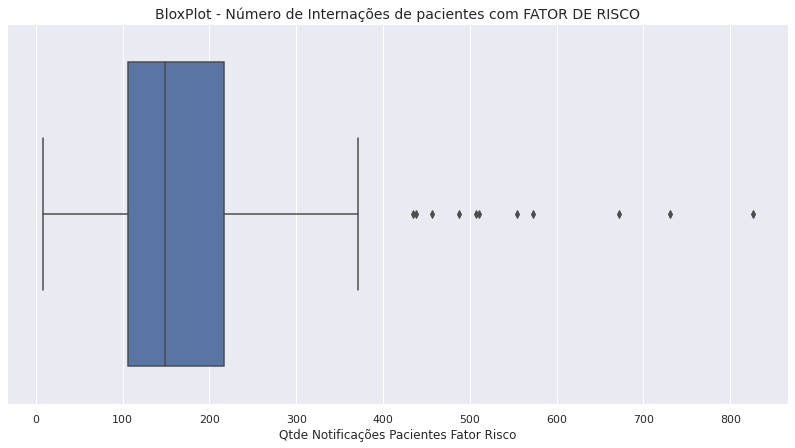

In [ ]:
# Usa a biblioteca SEABORN
# BoxPlot de pacientes semanal
plt.figure(figsize=(14,7))
boxplotSemanal_pac_fatorrisc = sns.boxplot(x=analise_tempor_interna_comobirdade['SUM_SEMANA_FATOR_RISC'])
plt.title('BloxPlot - Número de Internações de pacientes com FATOR DE RISCO', fontsize=14)
boxplotSemanal_pac_fatorrisc.set(xlabel='Qtde Notificações Pacientes Fator Risco')
plt.show()

In [ ]:
def escore_z(vl_parte, vl_media, vl_desvio):
    return (vl_parte-vl_media)/vl_desvio

''' 
    Consideramos USUAIS os valores cujos escores padronizados estão entre -2 e 2,
    e incomuns os valores com escore z inferior a -2 ou superior 2
'''
def descricao_valor_escore(valor):
    result = ''
    if valor < -2 or valor > 2:
        result = 'valor incomum'
    return result

print('-------------------------------------------------')
print(' SEMANAS DE INTERNAÇÕES EM UTI ')
print('-------------------------------------------------')
for index, dados in analise_tempor_interna_comobirdade['SUM_SEMANA_UTI'].items():
    #print(dados)
    escore = '{:.4f}'.format(escore_z(dados, 
                              analise_tempor_interna_comobirdade['SUM_SEMANA_UTI'].mean(),
                              analise_tempor_interna_comobirdade['SUM_SEMANA_UTI'].std()))
    
    if float(escore) < -2 or float(escore) > 2: 
      print(escore + '\t' + str(dados) +str('\t'+descricao_valor_escore(float(escore))))
   
print('-------------------------------------------------')
print(' SEMANAS DE CASOS DE PACIENTES COM COMORBIDADES ')
print('-------------------------------------------------')
for index, dados in analise_tempor_interna_comobirdade['SUM_SEMANA_FATOR_RISC'].items():
    escore = '{:.4f}'.format(escore_z(dados, 
                              analise_tempor_interna_comobirdade['SUM_SEMANA_FATOR_RISC'].mean(),
                              analise_tempor_interna_comobirdade['SUM_SEMANA_FATOR_RISC'].std()))
    
    if float(escore) < -2 or float(escore) > 2:
      print(escore + '\t' + str(dados) +str('\t'+descricao_valor_escore(float(escore))))    

-------------------------------------------------
 SEMANAS DE INTERNAÇÕES EM UTI 
-------------------------------------------------
2.0043	268	valor incomum
4.1724	450	valor incomum
2.7786	333	valor incomum
2.0043	268	valor incomum
-------------------------------------------------
 SEMANAS DE CASOS DE PACIENTES COM COMORBIDADES 
-------------------------------------------------
2.0117	573	valor incomum
3.4287	826	valor incomum
2.8967	731	valor incomum
2.5662	672	valor incomum


###V - Correlação entre os casos de internação e comorbidade dos pacientes

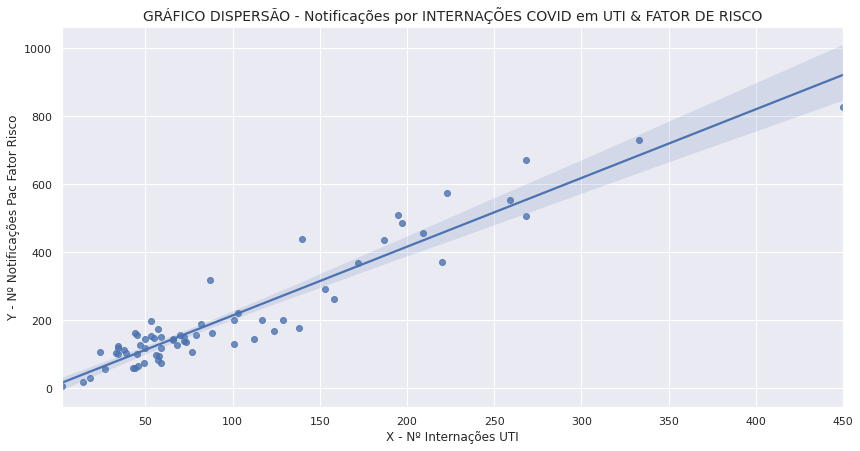

In [ ]:
plt.figure(figsize=(14,7))
plot_dispersao_intern_fatorrisc = sns.regplot(x = 'SUM_SEMANA_UTI', y = 'SUM_SEMANA_FATOR_RISC', data=analise_tempor_interna_comobirdade)
plt.title('GRÁFICO DISPERSÃO - Notificações por INTERNAÇÕES COVID em UTI & FATOR DE RISCO', fontsize=14) 
plot_dispersao_intern_fatorrisc.set(xlabel='X - Nº Internações UTI', ylabel='Y - Nº Notificações Pac Fator Risco')
plt.show();

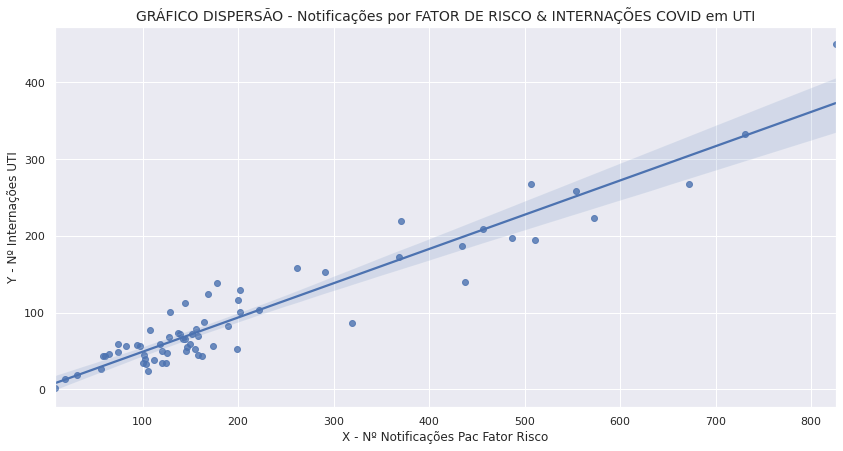

In [ ]:
plt.figure(figsize=(14,7))
plot_dispersao_intern_uti = sns.regplot(x = 'SUM_SEMANA_FATOR_RISC', y = 'SUM_SEMANA_UTI', data=analise_tempor_interna_comobirdade)
plt.title('GRÁFICO DISPERSÃO - Notificações por FATOR DE RISCO & INTERNAÇÕES COVID em UTI', fontsize=14)
plot_dispersao_intern_uti.set(xlabel='X - Nº Notificações Pac Fator Risco', ylabel='Y - Nº Internações UTI')
plt.show();

###VI - Idade dos pacientes que foram internados e/ou comórbidos

Total Elementos: 28006
Elementos NaN: 0
Elementos não NaN: 28006


Tabela ROL: [  0.   0.   0. ... 110. 110. 114.]
Idade mínimo: 0.0
Idade máximo: 114.0
Idades e suas Frequências


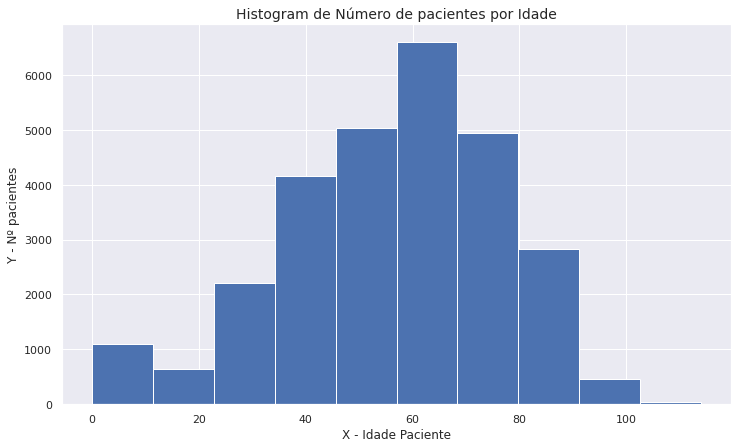

In [ ]:
import numpy as np

''' 
  DISTRIBUIÇÃO DE FREQUÊNCIA DAS IDADES DOS PACINETES
'''

idades_pacientes = np.sort(srag.IDADE.values) # Ordena as idades
#print(idades_pacientes)

print('Total Elementos: '+str(len(idades_pacientes)))    
print('Elementos NaN: '+str(np.count_nonzero(np.isnan(idades_pacientes)))) # NaN values
print('Elementos não NaN: '+str(np.count_nonzero(~np.isnan(idades_pacientes)))) # Not NaN values

idades_pacientes = idades_pacientes[~np.isnan(idades_pacientes)] # Exclusão de valores NaN

print('\n')
print('Tabela ROL: '+str(idades_pacientes))
print('Idade mínimo: '+str(idades_pacientes.min()))
print('Idade máximo: '+str(idades_pacientes.max()))

print('Idades e suas Frequências')

plt.figure(figsize=(12,7))
frequencia, classes = np.histogram(idades_pacientes)
hist_idade = plt.hist(idades_pacientes, bins=classes)
plt.title('Histogram de Número de pacientes por Idade', fontsize=14)
plt.xlabel('X - Idade Paciente') # fontsize=14
plt.ylabel('Y - Nº pacientes')
plt.show();

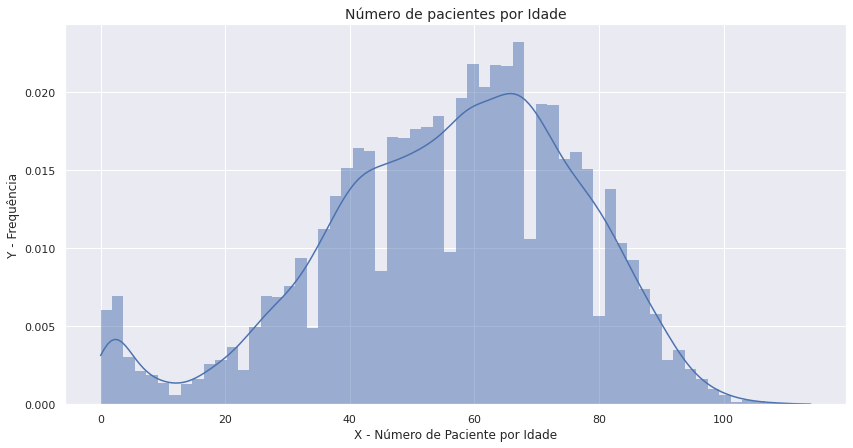

In [ ]:
#sns.distplot(idades_pacientes);
plt.figure(figsize=(14,7))
sns.histplot(idades_pacientes, kde=True, stat="density", linewidth=0);
plt.title('Número de pacientes por Idade', fontsize=14)
plt.xlabel('X - Número de Paciente por Idade') # fontsize=14
plt.ylabel('Y - Frequência')
plt.show();

In [ ]:
#from scipy import stats
print(min(idades_pacientes), max(idades_pacientes), np.std(idades_pacientes))

idades_pacientes.mean(), np.median(idades_pacientes), stats.mode(idades_pacientes)

0.0 114.0 20.56635107868204


(56.05238163250732, 58.0, ModeResult(mode=array([68.]), count=array([611])))

##3.5- Gráficos Interativos - FAIXA ETÁRIA, SEXO, FATOR DE RISCO, INTERNAÇÃO UTI

In [ ]:
# É um gráfico de dispersão que combina os atributos a CLASSE default
grafico = px.treemap(srag, path=['FAIXA_ETARIA','CS_SEXO', 'FATOR_RISC', 'UTI']) # Agrupo as GÊNERO, COMORBIDADES e INTERNADOS EM UTI
grafico.show()

In [ ]:
grafico = px.parallel_categories(srag, dimensions=['FAIXA_ETARIA','CS_SEXO', 'FATOR_RISC', 'UTI'], color="UTI", color_continuous_scale=px.colors.sequential.Inferno)
grafico.show()

##3.6 - Observações sobre os Estilos e Características dos pacientes
<p>
1 - Dentre as observações analisadas pelos dados disponíveis, <strong>mais de cinquenta por cento dos pacientes são homens (54%)</strong>, enquanto que as <strong>mulheres constituem quarenta e seis por cento</strong>.
</p>
<p>
2 - Quando falamos de <strong>raça/cor</strong>, observamos que os que foram declarados <strong>brancos e pardos juntos representam mais da metade dos pacientes referidos na análise (73%)</strong>, enquanto que os negros e indígenas não somam 6%. 
</p>
<p>
3 - Mais de 84% dos casos ocorrem nas cidades, o que pode ser explicado pelo alto povoamento em relação à zona rural.
</p>
<p>
4 - Em relação ao nível de escolaridade mais de sessenta por cento não foram determinados, no entanto, <strong>chama-se à atenção dentre os informados que o percentual com nível fundamental é superior aos demais</strong>.  (passível de investigação).
</p>
<p>
5 - Mais de <strong>80% dos casos foram classificados através de testes laboratoriais onde mais 50% dessas classificações foram SRAG por COVID-19</strong> que por fim, dentre o todo da população absoluta mais da metade resultaram em <strong>cura</strong>.
</p>

In [ ]:
# Gênero: M - Masculino | F - Feminino | I - Ignorado
sexo = srag.groupby(['CS_SEXO']).size().reset_index(name='counts')

# Raça/Cor: 1-Branca | 2-Preta | 3-Amarela | 4-Parda | 5-Indígena | 9-Ignorado
raca = srag.groupby(['CS_RACA']).size().reset_index(name='counts')

# Escolaridade
'''
0-Sem escolaridade/Analfabeto | 1-Fundamental 1º ciclo (1ª a 5ª série) | 2- Fundamental 2º ciclo (6ª a 9ª série)
3-Médio (1º ao 3º ano) | 4-Superior | 5-Não se aplica | 9-Ignorado
'''
escolaridade = srag.groupby(['CS_ESCOL_N']).size().reset_index(name='counts')

# Zona Residência: 1-Urbana | 2-Rural | 3-Periurbana | 9-Ignorado
zona = srag.groupby(['CS_ZONA']).size().reset_index(name='counts')

# Classificação Final do Caso
cassi_fin = srag.groupby(['CLASSI_FIN']).size().reset_index(name='counts')

# Internações em UTI
internacao_uti = srag.groupby(['UTI']).size().reset_index(name='counts')

# Internações com uso Suporte Ventilatória
internacao_ventilador = srag.groupby(['SUPORT_VEN']).size().reset_index(name='counts')

# Pacientes com Fator de Risco (COMORBIDADE)
paciente_fato_risco = srag.groupby(['FATOR_RISC']).size().reset_index(name='counts')

# Classe que Monta a Lengenda dos COUNTPLOT do SEABORN
class TextHandler(HandlerBase):
    def create_artists(self, legend, tup ,xdescent, ydescent,
                        width, height, fontsize,trans):
        tx = Text(width/2.,height/2,tup[0], fontsize=fontsize,
                  ha="center", va="center", color=tup[1], fontweight="bold")
        return [tx]

def value_option(column_name,value):
    if column_name == 'UTI':
        if value == 1:
            return 'SIM'
        elif value == 2:
            return 'NAO'
        elif value == 9:
            return 'IGNORADO'
    elif column_name == 'SUPORT_VEN':
        if value == 1:
            return 'SIM, INVASIVO'
        elif value == 2:
            return 'SIM, NAO INVASIVO'
        elif value == 3:
            return 'NAO'
        elif value == 9:
            return 'IGNORADO'
    elif column_name == 'CS_RACA':
        if value == 1:
            return 'BRANCA'
        elif value == 2:
            return 'PRETA'
        elif value == 3:
            return 'AMARELA'
        elif value == 4:
            return 'PARDA'
        elif value == 5:
            return 'INDIGENA'
        elif value == 9:
            return 'IGNORADO'
    elif column_name == 'CS_ESCOL_N':
        if value == 0:
            return 'IGNORADO'
        elif value == 1:
            return 'FUNDAMENTAL 1 CICLO'
        elif value == 2:
            return 'FUNDAMENTAL 2 CICLO'
        elif value == 3:
            return 'MEDIO'
        elif value == 4:
            return 'SUPERIOR'
        elif value == 5:
            return 'NAO APLICA'
        elif value == 9:
            return 'IGNORADO'
    elif column_name == 'CS_ZONA':
        if value == 1:
            return 'URBANA'
        elif value == 2:
            return 'RURAL'
        elif value == 3:
            return 'PERIURBANA'
        elif value == 9:
            return 'IGNORADO'

In [ ]:
# from prettytable import PrettyTable   
table_sexo = PrettyTable()
table_raca = PrettyTable()
table_escolaridade = PrettyTable()
table_zona = PrettyTable()
table_cassi_fin = PrettyTable()
table_internacao_uti = PrettyTable()
table_internacao_ventilador = PrettyTable()
table_paciente_fato_risco = PrettyTable()

table_cassi_fin.field_names = ["CLASSIF_FINAL_CASO", "COUNTS", "%"]
for index, classificacao in cassi_fin.iterrows():
    table_cassi_fin.add_row([classificacao['CLASSI_FIN'], 
                             classificacao['counts'],
                             (lambda val_parte, val_todo : round(((val_parte/val_todo)*100),2))(classificacao['counts'],cassi_fin['counts'].sum())
                             ])

table_sexo.field_names = ["GENERO", "COUNTS", "%"]
for index, genero in sexo.iterrows():
    table_sexo.add_row([genero['CS_SEXO'],  
                        genero['counts'],
                        (lambda val_parte, val_todo : round(((val_parte/val_todo)*100),2))(genero['counts'],sexo['counts'].sum())
                        ])

table_raca.field_names = ["RACA", "COUNTS", "%"]
for index, racas in raca.iterrows():
    table_raca.add_row([value_option('CS_RACA',racas['CS_RACA']), 
                        racas['counts'],
                        (lambda val_parte, val_todo : round(((val_parte/val_todo)*100),2))(racas['counts'],raca['counts'].sum())
                        ])

table_escolaridade.field_names = ["ESCOLARIDADE", "COUNTS", "%"]
for index, escolaridades in escolaridade.iterrows():
    table_escolaridade.add_row([value_option('CS_ESCOL_N',escolaridades['CS_ESCOL_N']),  
                                escolaridades['counts'],
                                (lambda val_parte, val_todo : round(((val_parte/val_todo)*100),2))(escolaridades['counts'],escolaridade['counts'].sum())
                                ])

table_zona.field_names = ["ZONA_RESID_PACIENTE", "COUNTS", "%"]
for index, residencia in zona.iterrows():
    table_zona.add_row([value_option('CS_ZONA',residencia['CS_ZONA']), 
                        residencia['counts'],
                        (lambda val_parte, val_todo : round(((val_parte/val_todo)*100),2))(residencia['counts'],zona['counts'].sum())
                        ])

table_internacao_uti.field_names = ["INTERNACAO_UTI", "COUNTS", "%"]
for index, inter_uti in internacao_uti.iterrows():
    table_internacao_uti.add_row([value_option('UTI', inter_uti['UTI']), 
                        inter_uti['counts'],
                        (lambda val_parte, val_todo : round(((val_parte/val_todo)*100),2))(inter_uti['counts'],internacao_uti['counts'].sum())
                        ])

table_internacao_ventilador.field_names = ["INTERNACAO_UTI_VENTILADOR", "COUNTS", "%"]
for index, inter_uti_vent in internacao_ventilador.iterrows():
    table_internacao_ventilador.add_row([value_option('SUPORT_VEN',inter_uti_vent['SUPORT_VEN']), 
                        inter_uti_vent['counts'],
                        (lambda val_parte, val_todo : round(((val_parte/val_todo)*100),2))(inter_uti_vent['counts'],internacao_ventilador['counts'].sum())
                        ])
    
table_paciente_fato_risco.field_names = ["PACIENTE_COMORBIDADE", "COUNTS", "%"]
for index, fatorrisco in paciente_fato_risco.iterrows():
    table_paciente_fato_risco.add_row([fatorrisco['FATOR_RISC'], 
                        fatorrisco['counts'],
                        (lambda val_parte, val_todo : round(((val_parte/val_todo)*100),2))(fatorrisco['counts'],paciente_fato_risco['counts'].sum())
                        ])
                                       


print(table_sexo)
print(table_zona)

+--------+--------+-------+
| GENERO | COUNTS |   %   |
+--------+--------+-------+
|   F    | 12495  | 44.62 |
|   I    |   1    |  0.0  |
|   M    | 15510  | 55.38 |
+--------+--------+-------+
+---------------------+---------+-------+
| ZONA_RESID_PACIENTE |  COUNTS |   %   |
+---------------------+---------+-------+
|        URBANA       | 24809.0 | 88.58 |
|        RURAL        |  1792.0 |  6.4  |
|      PERIURBANA     |   58.0  |  0.21 |
|       IGNORADO      |  1347.0 |  4.81 |
+---------------------+---------+-------+


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


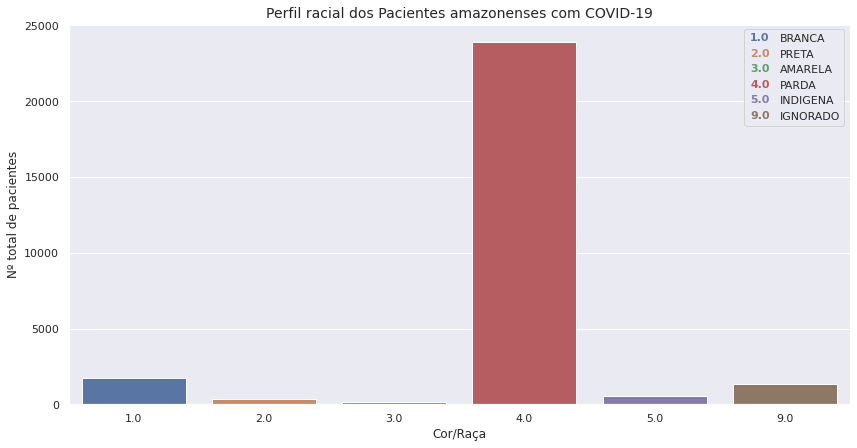

----------------------------------------------------------
+----------+---------+------+
|   RACA   |  COUNTS |  %   |
+----------+---------+------+
|  BRANCA  |  1715.0 | 6.12 |
|  PRETA   |  326.0  | 1.16 |
| AMARELA  |  123.0  | 0.44 |
|  PARDA   | 23917.0 | 85.4 |
| INDIGENA |  557.0  | 1.99 |
| IGNORADO |  1368.0 | 4.88 |
+----------+---------+------+


In [ ]:
# Usa a biblioteca SEABORN

# GRÁFICO BARRA - GÊNERO
plt.figure(figsize=(14,7))
bar_plot_genero = sns.countplot(srag['CS_RACA'])
bar_plot_genero.set_xticklabels(bar_plot_genero.get_xticklabels(),rotation=0);
plt.title('Perfil racial dos Pacientes amazonenses com COVID-19', fontsize=14)
bar_plot_genero.set(xlabel='Cor/Raça', ylabel='Nº total de pacientes')

# Legenda
handltext = ["1.0", "2.0", "3.0", "4.0","5.0","9.0"] # Chaves de identificação das Legendas
labels = ["BRANCA", "PRETA", "AMARELA", "PARDA","INDIGENA", "IGNORADO"] # Valores das legendas

t = bar_plot_genero.get_xticklabels()
labeldic = dict(zip(handltext, labels))
labels = [labeldic[h.get_text()]  for h in t]
handles = [(h.get_text(),c.get_fc()) for h,c in zip(t,bar_plot_genero.patches)]
bar_plot_genero.legend(handles, labels, handler_map={tuple : TextHandler()}) 

#plt.xticks(rotation=90)
plt.show()
print('----------------------------------------------------------')
print(table_raca)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


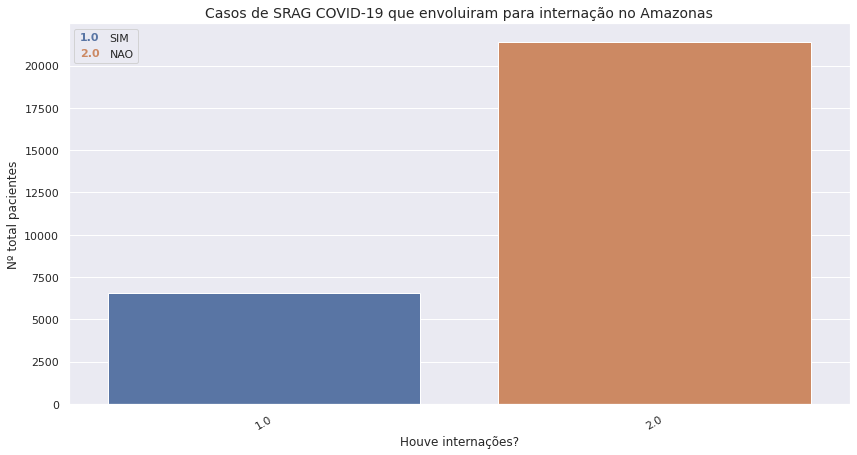

------------------------------------------------------
+----------------+---------+-------+
| INTERNACAO_UTI |  COUNTS |   %   |
+----------------+---------+-------+
|      SIM       |  6583.0 | 23.51 |
|      NAO       | 21423.0 | 76.49 |
+----------------+---------+-------+


In [ ]:
# Usa a biblioteca SEABORN
# GRÁFICO BARRA - INTERNAÇÕES
plt.figure(figsize=(14,7))
bar_internacao_uti = sns.countplot(srag['UTI'])
bar_internacao_uti.set_xticklabels(bar_internacao_uti.get_xticklabels(),rotation=30);
plt.title('Casos de SRAG COVID-19 que envoluiram para internação no Amazonas', fontsize=14)
bar_internacao_uti.set(xlabel='Houve internações?', ylabel='Nº total pacientes');

handltext = ["1.0", "2.0"] # Chaves de identificação das Legendas
labels = ["SIM", "NAO"] # Valores das legendas

t = bar_internacao_uti.get_xticklabels()
labeldic = dict(zip(handltext, labels))
labels = [labeldic[h.get_text()]  for h in t]
handles = [(h.get_text(),c.get_fc()) for h,c in zip(t,bar_internacao_uti.patches)]
bar_internacao_uti.legend(handles, labels, handler_map={tuple : TextHandler()}) 

plt.show();
print('------------------------------------------------------')
print(table_internacao_uti)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


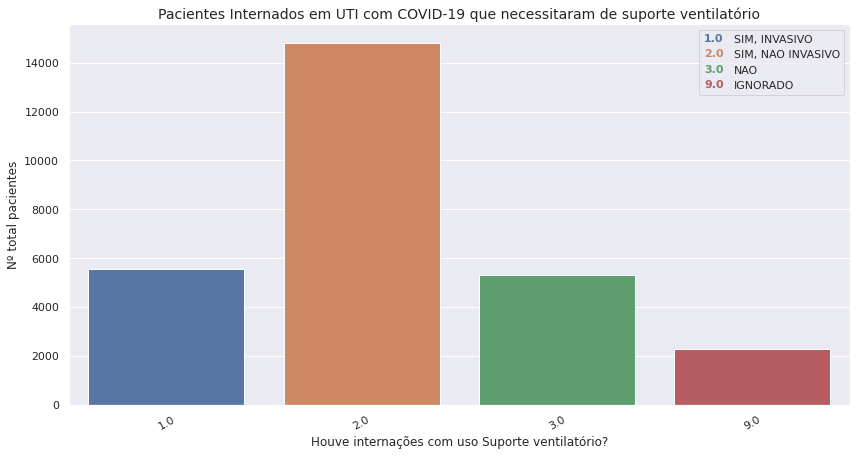

-------------------------------------------------------
+---------------------------+---------+-------+
| INTERNACAO_UTI_VENTILADOR |  COUNTS |   %   |
+---------------------------+---------+-------+
|       SIM, INVASIVO       |  5543.0 | 19.79 |
|     SIM, NAO INVASIVO     | 14822.0 | 52.92 |
|            NAO            |  5334.0 | 19.05 |
|          IGNORADO         |  2307.0 |  8.24 |
+---------------------------+---------+-------+


In [ ]:
# Usa a biblioteca SEABORN
# GRÁFICO BARRA - INTERNAÇÕES COM USO SUPORTE VENTILATÓRIO
plt.figure(figsize=(14,7))
bar_internacao_uti_ventilador = sns.countplot(srag['SUPORT_VEN'])
bar_internacao_uti_ventilador.set_xticklabels(bar_internacao_uti_ventilador.get_xticklabels(),rotation=30);
plt.title('Pacientes Internados em UTI com COVID-19 que necessitaram de suporte ventilatório', fontsize=14)
bar_internacao_uti_ventilador.set(xlabel='Houve internações com uso Suporte ventilatório?', ylabel='Nº total pacientes');

handltext = ["1.0", "2.0", "3.0", "9.0"] # Chaves de identificação das Legendas
labels = ["SIM, INVASIVO", "SIM, NAO INVASIVO", "NAO", "IGNORADO"] # Valores das legendas

t = bar_internacao_uti_ventilador.get_xticklabels()
labeldic = dict(zip(handltext, labels))
labels = [labeldic[h.get_text()]  for h in t]
handles = [(h.get_text(),c.get_fc()) for h,c in zip(t,bar_internacao_uti_ventilador.patches)]
bar_internacao_uti_ventilador.legend(handles, labels, handler_map={tuple : TextHandler()}) 

plt.show()
print('-------------------------------------------------------')
print(table_internacao_ventilador);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


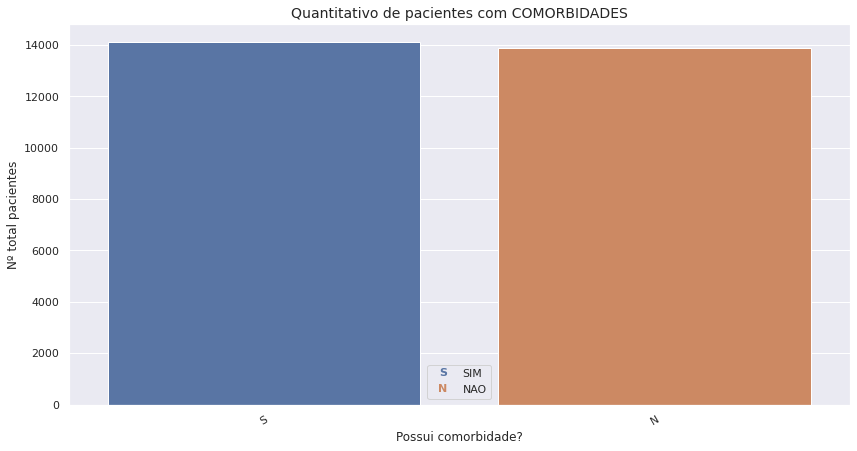

------------------------------------------------------
+----------------------+--------+-------+
| PACIENTE_COMORBIDADE | COUNTS |   %   |
+----------------------+--------+-------+
|          N           | 13895  | 49.61 |
|          S           | 14111  | 50.39 |
+----------------------+--------+-------+


In [ ]:
# Usa a biblioteca SEABORN
# GRÁFICO BARRA - INTERNAÇÕES
plt.figure(figsize=(14,7))
bar_fator_risco = sns.countplot(srag['FATOR_RISC'])
bar_fator_risco.set_xticklabels(bar_fator_risco.get_xticklabels(),rotation=30);
plt.title('Quantitativo de pacientes com COMORBIDADES', fontsize=14)
bar_fator_risco.set(xlabel='Possui comorbidade?', ylabel='Nº total pacientes');

handltext = ["S", "N"] # Chaves de identificação das Legendas
labels = ["SIM", "NAO"] # Valores das legendas

t = bar_fator_risco.get_xticklabels()
labeldic = dict(zip(handltext, labels))
labels = [labeldic[h.get_text()]  for h in t]
handles = [(h.get_text(),c.get_fc()) for h,c in zip(t,bar_fator_risco.patches)]
bar_fator_risco.legend(handles, labels, handler_map={tuple : TextHandler()}) 

plt.show();
print('------------------------------------------------------')
print(table_paciente_fato_risco);

##3.7 - Análise de Causalidade entre as internações e comorbidades

<p>Desejo saber quantos pacientes da amostra com COMORBIDADES foram INTERNADOS em UTI</p>

In [ ]:
notific_pac_com_comorbidade_internado = srag.query('UTI==1 and FATOR_RISC=="S"') # Filtro de Interseção

print(notific_pac_com_comorbidade_internado.groupby(['FAIXA_ETARIA']).size().reset_index(name='counts'))
print('=================================================')
print('Total pacientes INTERNADOS: '+str(analise_tempor_interna_comobirdade['SUM_SEMANA_UTI'].sum()))
print('Total pacientes COMORBIDADES: '+str(analise_tempor_interna_comobirdade['SUM_SEMANA_FATOR_RISC'].sum()))
print('Total pacientes INTERNADOS com COMORBIDADE: '+str(notific_pac_com_comorbidade_internado['DT_SIN_PRI'].count()))
print('=================================================')
perc_inter_com_comorbidade = (lambda val_parte, val_todo : round(((val_parte/val_todo)*100),2))(notific_pac_com_comorbidade_internado['DT_SIN_PRI'].count(), analise_tempor_interna_comobirdade['SUM_SEMANA_UTI'].sum())
perc_comor_foram_internados = (lambda val_parte, val_todo : round(((val_parte/val_todo)*100),2))(notific_pac_com_comorbidade_internado['DT_SIN_PRI'].count(), analise_tempor_interna_comobirdade['SUM_SEMANA_FATOR_RISC'].sum())
print('Percentual de INTERNADOS com COMORBIDADE (em relação ao total INTERNAÇÃO): '+str(perc_inter_com_comorbidade) + '%')
print('Percentual de pac. COMORBIDADES que precisaram de INTERNAÇÃO (em relação ao total c/ COMORBIDADES): '+str(perc_comor_foram_internados) + '%')

diaria_internacao_com_comorbi = notific_pac_com_comorbidade_internado.groupby(['DT_SIN_PRI']).size().reset_index(name='counts')
diaria_internacao_com_comorbi['SEMANA'] = diaria_internacao_com_comorbi['DT_SIN_PRI'].dt.to_period('W-THU') # Adiciona a SEMANA

diaria_internacao_com_comorbi = diaria_internacao_com_comorbi.groupby(['SEMANA'])['counts'].agg('sum').reset_index(name='SUM')

  FAIXA_ETARIA  counts
0         < 60    1624
1        >= 60    2493
Total pacientes INTERNADOS: 6583
Total pacientes COMORBIDADES: 14111
Total pacientes INTERNADOS com COMORBIDADE: 4117
Percentual de INTERNADOS com COMORBIDADE (em relação ao total INTERNAÇÃO): 62.54%
Percentual de pac. COMORBIDADES que precisaram de INTERNAÇÃO (em relação ao total c/ COMORBIDADES): 29.18%


In [ ]:
# <<< DISTRIBUIÇÃO DISCRETA DE PROBABILIDADE >>>
# Probabilidade de notificações de Internações

table_distrib_prob_internacao_uti = PrettyTable()
print('Soma total de Internações: '+str(analise_tempor_interna_comobirdade['SUM_SEMANA_UTI'].sum()))
print('Soma total de pac comorbidades: '+str(analise_tempor_interna_comobirdade['SUM_SEMANA_FATOR_RISC'].sum()))
print('----------------------------------------')

total_internacao_uti = [] # Total de internações em UTI
total_probabilidades = [] # Total de probabilidades
produto_prob_por_semana = []

table_distrib_prob_internacao_uti.field_names = ["SEMANA", "NUM_INTERNACAO_UTI", "PROBABILIDADES"]
for index, notificacao in diaria_internacao_com_comorbi.iterrows():
    total_internacao_uti.append(int(notificacao['SUM'])) # Adiciona as freq de notificações na Lista
    total_probabilidades.append(float('{:.4f}'.format(notificacao.SUM/diaria_internacao_com_comorbi['SUM'].sum())))
    produto_prob_por_semana.append((int(index)+1)*(float('{:.4f}'.format(notificacao.SUM/diaria_internacao_com_comorbi['SUM'].sum()))))
    table_distrib_prob_internacao_uti.add_row([
                                                int(index)+1, 
                                                notificacao['SUM'],
                                                float('{:.4f}'.format(notificacao.SUM/diaria_internacao_com_comorbi['SUM'].sum()))
                                              ])
table_distrib_prob_internacao_uti.add_row(['TOTAL', sum(total_internacao_uti), sum(total_probabilidades)])    
print(table_distrib_prob_internacao_uti)
print('MÉDIA DISTRIBUIÇÃO DE PROBABILIDADE')
print('Internações por semana: {:.2f}'.format(sum(produto_prob_por_semana)))

Soma total de Internações: 6583
Soma total de pac comorbidades: 14111
----------------------------------------
+--------+--------------------+----------------+
| SEMANA | NUM_INTERNACAO_UTI | PROBABILIDADES |
+--------+--------------------+----------------+
|   1    |         9          |     0.0022     |
|   2    |         40         |     0.0097     |
|   3    |         88         |     0.0214     |
|   4    |        131         |     0.0318     |
|   5    |        202         |     0.0491     |
|   6    |        172         |     0.0418     |
|   7    |        154         |     0.0374     |
|   8    |        137         |     0.0333     |
|   9    |        110         |     0.0267     |
|   10   |         63         |     0.0153     |
|   11   |         45         |     0.0109     |
|   12   |         39         |     0.0095     |
|   13   |         32         |     0.0078     |
|   14   |         37         |     0.009      |
|   15   |         28         |     0.0068     |
|   16 

###Análise sobre os Sintomas de COVID-19 sentido pelos pacientes

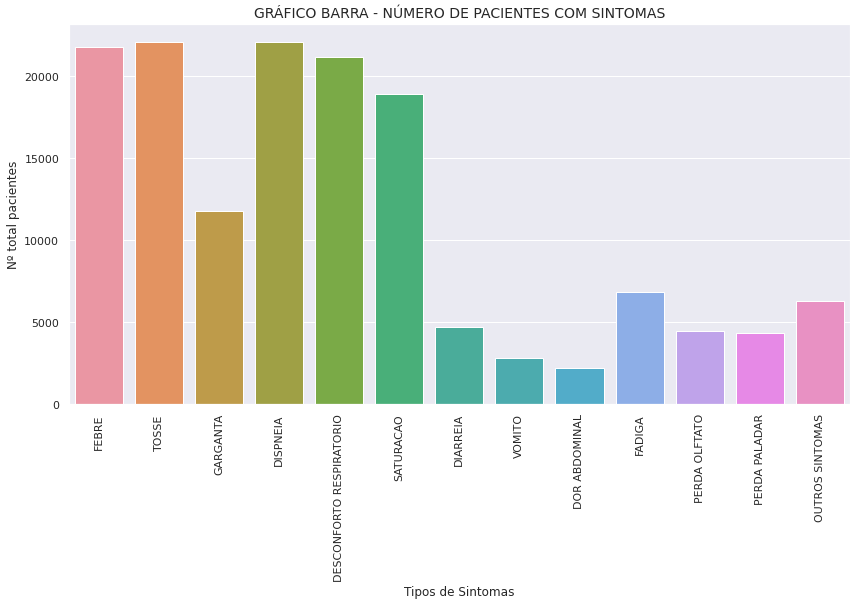

,sintomas,qtde,%
1,TOSSE,22098.0,78.90
3,DISPNEIA,22072.0,78.81
0,FEBRE,21774.0,77.75
4,DESCONFORTO RESPIRATORIO,21157.0,75.54
5,SATURACAO,18922.0,67.56
2,GARGANTA,11775.0,42.04
9,FADIGA,6845.0,24.44
12,OUTROS SINTOMAS,6303.0,22.51
6,DIARREIA,4747.0,16.95
10,PERDA OLFTATO,4489.0,16.03


In [ ]:
qtde_febre = srag.groupby(['FEBRE']).size().reset_index(name='counts')
qtde_tosse = srag.groupby(['TOSSE']).size().reset_index(name='counts')
qtde_garganta = srag.groupby(['GARGANTA']).size().reset_index(name='counts')
qtde_dispneia = srag.groupby(['DISPNEIA']).size().reset_index(name='counts')
qtde_resp = srag.groupby(['DESC_RESP']).size().reset_index(name='counts')
qtde_saturacao = srag.groupby(['SATURACAO']).size().reset_index(name='counts')
qtde_diarreia = srag.groupby(['DIARREIA']).size().reset_index(name='counts')
qtde_vomito = srag.groupby(['VOMITO']).size().reset_index(name='counts')
qtde_dor_abd = srag.groupby(['DOR_ABD']).size().reset_index(name='counts')
qtde_fadiga = srag.groupby(['FADIGA']).size().reset_index(name='counts')
qtde_perda_olft = srag.groupby(['PERD_OLFT']).size().reset_index(name='counts')
qtde_perda_paladar = srag.groupby(['PERD_PALA']).size().reset_index(name='counts')
qtde_outros = srag.groupby(['OUTRO_SIN']).size().reset_index(name='counts')

query_febre     = qtde_febre.query('FEBRE == 1')
query_tosse     = qtde_tosse.query('TOSSE == 1')
query_garganta  = qtde_garganta.query('GARGANTA == 1')
query_dispneia  = qtde_dispneia.query('DISPNEIA == 1')
query_resp      = qtde_resp.query('DESC_RESP == 1')
query_saturacao = qtde_saturacao.query('SATURACAO == 1')
query_diarreia  = qtde_diarreia.query('DIARREIA == 1')
query_vomito    = qtde_vomito.query('VOMITO == 1')
query_dor_abd   = qtde_dor_abd.query('DOR_ABD == 1')
query_fadiga    = qtde_fadiga.query('FADIGA == 1')
query_perda_olft = qtde_perda_olft.query('PERD_OLFT == 1')
query_perda_paladar = qtde_perda_paladar.query('PERD_PALA == 1')
query_outros        = qtde_outros.query('OUTRO_SIN == 1')

dados = [['FEBRE',query_febre.iloc[0].counts, float('{:.2f}'.format((query_febre.iloc[0].counts / srag['FEBRE'].count() ) * 100))],	
         ['TOSSE',query_tosse.iloc[0].counts, float('{:.2f}'.format((query_tosse.iloc[0].counts / srag['TOSSE'].count() ) * 100))],	
         ['GARGANTA',query_garganta.iloc[0].counts, float('{:.2f}'.format((query_garganta.iloc[0].counts / srag['GARGANTA'].count() ) * 100))],	
         ['DISPNEIA',query_dispneia.iloc[0].counts, float('{:.2f}'.format((query_dispneia.iloc[0].counts / srag['DISPNEIA'].count() ) * 100))],	
         ['DESCONFORTO RESPIRATORIO',query_resp.iloc[0].counts, float('{:.2f}'.format((query_resp.iloc[0].counts / srag['DESC_RESP'].count() ) * 100))],	
         ['SATURACAO',query_saturacao.iloc[0].counts, float('{:.2f}'.format((query_saturacao.iloc[0].counts / srag['SATURACAO'].count() ) * 100))],	
         ['DIARREIA',query_diarreia.iloc[0].counts, float('{:.2f}'.format((query_diarreia.iloc[0].counts / srag['DIARREIA'].count() ) * 100))],	
         ['VOMITO',query_vomito.iloc[0].counts, float('{:.2f}'.format((query_vomito.iloc[0].counts / srag['VOMITO'].count() ) * 100))],	
         ['DOR ABDOMINAL',query_dor_abd.iloc[0].counts, float('{:.2f}'.format((query_dor_abd.iloc[0].counts / srag['DOR_ABD'].count() ) * 100))],	
         ['FADIGA',query_fadiga.iloc[0].counts, float('{:.2f}'.format((query_fadiga.iloc[0].counts / srag['FADIGA'].count() ) * 100))],
         ['PERDA OLFTATO',query_perda_olft.iloc[0].counts, float('{:.2f}'.format((query_perda_olft.iloc[0].counts / srag['PERD_OLFT'].count() ) * 100))],	
         ['PERDA PALADAR',query_perda_paladar.iloc[0].counts, float('{:.2f}'.format((query_perda_paladar.iloc[0].counts / srag['PERD_PALA'].count() ) * 100))],	
         ['OUTROS SINTOMAS',query_outros.iloc[0].counts, float('{:.2f}'.format((query_outros.iloc[0].counts / srag['OUTRO_SIN'].count() ) * 100))]]

sintomas = pd.DataFrame(dados, columns = ['sintomas', 'qtde', '%'])

plt.figure(figsize=(14,7))
bar_sintomas = sns.barplot(x="sintomas", y="qtde", data=sintomas)
bar_sintomas.set_xticklabels(bar_sintomas.get_xticklabels(),rotation=90);
plt.title('GRÁFICO BARRA - NÚMERO DE PACIENTES COM SINTOMAS', fontsize=14)
bar_sintomas.set(xlabel='Tipos de Sintomas', ylabel='Nº total pacientes');
plt.show();
sintomas.sort_values(by='qtde', ascending=False)

###Análise sobre as comorbidades encontradas nos pacientes

In [ ]:
srag_uti = srag.query('UTI == 1')
qtde_puerpera   = srag_uti.groupby(['PUERPERA']).size().reset_index(name='counts')
qtde_cardiopati = srag_uti.groupby(['CARDIOPATI']).size().reset_index(name='counts')
qtde_hematologi = srag_uti.groupby(['HEMATOLOGI']).size().reset_index(name='counts')
qtde_sind_down  = srag_uti.groupby(['SIND_DOWN']).size().reset_index(name='counts')
qtde_hepatica   = srag_uti.groupby(['HEPATICA']).size().reset_index(name='counts')
qtde_asma       = srag_uti.groupby(['ASMA']).size().reset_index(name='counts')
qtde_diabetes   = srag_uti.groupby(['DIABETES']).size().reset_index(name='counts')
qtde_neurologic = srag_uti.groupby(['NEUROLOGIC']).size().reset_index(name='counts')
qtde_pneumopati = srag_uti.groupby(['PNEUMOPATI']).size().reset_index(name='counts')
qtde_imunodepre = srag_uti.groupby(['IMUNODEPRE']).size().reset_index(name='counts')
qtde_renal      = srag_uti.groupby(['RENAL']).size().reset_index(name='counts')
qtde_obesidade  = srag_uti.groupby(['OBESIDADE']).size().reset_index(name='counts')
qtde_outros     = srag_uti.groupby(['OUT_MORBI']).size().reset_index(name='counts')

query_puerpera     = qtde_puerpera.query('PUERPERA == 1')
query_cardiopati   = qtde_cardiopati.query('CARDIOPATI == 1')
query_hematologi   = qtde_hematologi.query('HEMATOLOGI == 1')
query_sind_down    = qtde_sind_down.query('SIND_DOWN == 1')
query_hepatica     = qtde_hepatica.query('HEPATICA == 1')
query_asma         = qtde_asma.query('ASMA == 1')
query_diabetes     = qtde_diabetes.query('DIABETES == 1')
query_neurologic   = qtde_neurologic.query('NEUROLOGIC == 1')
query_pneumopati   = qtde_pneumopati.query('PNEUMOPATI == 1')
query_imunodepre   = qtde_imunodepre.query('IMUNODEPRE == 1')
query_renal        = qtde_renal.query('RENAL == 1')
query_obesidade    = qtde_obesidade.query('OBESIDADE == 1')
query_outros       = qtde_outros.query('OUT_MORBI == 1')

                       doencas    qtde
0                     PUERPERA    53.0
1       CARDIOVASCULAR_CRONICA  2027.0
2         HEMATOLOGICA_CRONICA    51.0
3                SINDROME_DOWN    34.0
4             HEPATICA_CRONICA    64.0
5                         ASMA   117.0
6            DIABETES_MELLITUS  1759.0
7          NEUROLOGICA_CRONICA   182.0
8          PNEUMOPATIA_CRONICA   180.0
9   IMUNODEFICIENCIA_DEPRESSAO   138.0
10               RENAL_CRONICA   340.0
11                   OBESIDADE   546.0
12                      OUTROS  1742.0


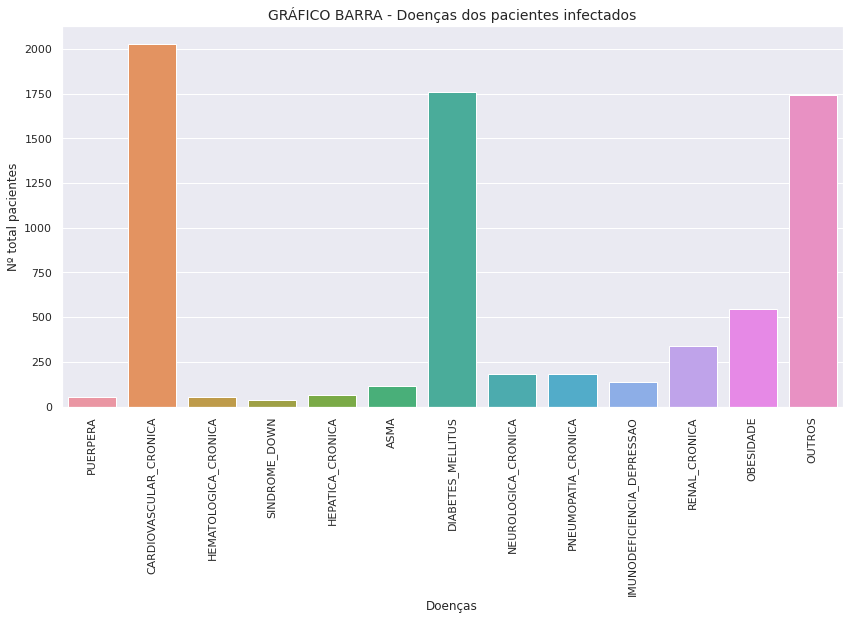

In [ ]:
dados = [['PUERPERA',query_puerpera.iloc[0].counts],  ['CARDIOVASCULAR_CRONICA',query_cardiopati.iloc[0].counts],
         ['HEMATOLOGICA_CRONICA',query_hematologi.iloc[0].counts],  ['SINDROME_DOWN',query_sind_down.iloc[0].counts],
         ['HEPATICA_CRONICA',query_hepatica.iloc[0].counts],	['ASMA',query_asma.iloc[0].counts],
         ['DIABETES_MELLITUS',query_diabetes.iloc[0].counts],	['NEUROLOGICA_CRONICA',query_neurologic.iloc[0].counts],
         ['PNEUMOPATIA_CRONICA',query_pneumopati.iloc[0].counts], ['IMUNODEFICIENCIA_DEPRESSAO',query_imunodepre.iloc[0].counts],
         ['RENAL_CRONICA',query_renal.iloc[0].counts],	['OBESIDADE',query_obesidade.iloc[0].counts],
         ['OUTROS',query_outros.iloc[0].counts]]


fatores_risco = pd.DataFrame(dados, columns = ['doencas', 'qtde'])

#print((lambda val_parte, val_todo : round(((val_parte/val_todo)*100),2))(sintomas['qtde'],sintomas['qtde'].sum()))

print(fatores_risco)
print('=====================================================')

# GRÁFICO
plt.figure(figsize=(14,7))
bar_doencas = sns.barplot(x="doencas", y="qtde", data=fatores_risco)
bar_doencas.set_xticklabels(bar_doencas.get_xticklabels(),rotation=90);
plt.title('GRÁFICO BARRA - Doenças dos pacientes infectados', fontsize=14)
bar_doencas.set(xlabel='Doenças', ylabel='Nº total pacientes');
plt.show();

In [ ]:
srag_uti_maior_igual_60 = srag.query('UTI == 1 and FAIXA_ETARIA == ">= 60"')
srag_uti_menor_60 = srag.query('UTI == 1 and FAIXA_ETARIA == "< 60"')

# MAIOR OU IGUAL A 60 ANOS
qtde_puerpera_maior_igual_60   = srag_uti_maior_igual_60.groupby(['PUERPERA']).size().reset_index(name='counts')
qtde_cardiopati_maior_igual_60 = srag_uti_maior_igual_60.groupby(['CARDIOPATI']).size().reset_index(name='counts')
qtde_hematologi_maior_igual_60 = srag_uti_maior_igual_60.groupby(['HEMATOLOGI']).size().reset_index(name='counts')
qtde_sind_down_maior_igual_60  = srag_uti_maior_igual_60.groupby(['SIND_DOWN']).size().reset_index(name='counts')
qtde_hepatica_maior_igual_60   = srag_uti_maior_igual_60.groupby(['HEPATICA']).size().reset_index(name='counts')
qtde_asma_maior_igual_60       = srag_uti_maior_igual_60.groupby(['ASMA']).size().reset_index(name='counts')
qtde_diabetes_maior_igual_60   = srag_uti_maior_igual_60.groupby(['DIABETES']).size().reset_index(name='counts')
qtde_neurologic_maior_igual_60 = srag_uti_maior_igual_60.groupby(['NEUROLOGIC']).size().reset_index(name='counts')
qtde_pneumopati_maior_igual_60 = srag_uti_maior_igual_60.groupby(['PNEUMOPATI']).size().reset_index(name='counts')
qtde_imunodepre_maior_igual_60 = srag_uti_maior_igual_60.groupby(['IMUNODEPRE']).size().reset_index(name='counts')
qtde_renal_maior_igual_60      = srag_uti_maior_igual_60.groupby(['RENAL']).size().reset_index(name='counts')
qtde_obesidade_maior_igual_60  = srag_uti_maior_igual_60.groupby(['OBESIDADE']).size().reset_index(name='counts')
qtde_outros_maior_igual_60     = srag_uti_maior_igual_60.groupby(['OUT_MORBI']).size().reset_index(name='counts')

# MENOR DE 60 ANOS
qtde_puerpera_menor_60   = srag_uti_menor_60.groupby(['PUERPERA']).size().reset_index(name='counts')
qtde_cardiopati_menor_60 = srag_uti_menor_60.groupby(['CARDIOPATI']).size().reset_index(name='counts')
qtde_hematologi_menor_60 = srag_uti_menor_60.groupby(['HEMATOLOGI']).size().reset_index(name='counts')
qtde_sind_down_menor_60  = srag_uti_menor_60.groupby(['SIND_DOWN']).size().reset_index(name='counts')
qtde_hepatica_menor_60   = srag_uti_menor_60.groupby(['HEPATICA']).size().reset_index(name='counts')
qtde_asma_menor_60       = srag_uti_menor_60.groupby(['ASMA']).size().reset_index(name='counts')
qtde_diabetes_menor_60   = srag_uti_menor_60.groupby(['DIABETES']).size().reset_index(name='counts')
qtde_neurologic_menor_60 = srag_uti_menor_60.groupby(['NEUROLOGIC']).size().reset_index(name='counts')
qtde_pneumopati_menor_60 = srag_uti_menor_60.groupby(['PNEUMOPATI']).size().reset_index(name='counts')
qtde_imunodepre_menor_60 = srag_uti_menor_60.groupby(['IMUNODEPRE']).size().reset_index(name='counts')
qtde_renal_menor_60      = srag_uti_menor_60.groupby(['RENAL']).size().reset_index(name='counts')
qtde_obesidade_menor_60  = srag_uti_menor_60.groupby(['OBESIDADE']).size().reset_index(name='counts')
qtde_outros_menor_60     = srag_uti_menor_60.groupby(['OUT_MORBI']).size().reset_index(name='counts')

# MAIOR OU IGUAL A 60 ANOS
query_puerpera_maior_igual_60     = qtde_puerpera_maior_igual_60.query('PUERPERA == 1')
query_cardiopati_maior_igual_60   = qtde_cardiopati_maior_igual_60.query('CARDIOPATI == 1')
query_hematologi_maior_igual_60   = qtde_hematologi_maior_igual_60.query('HEMATOLOGI == 1')
query_sind_down_maior_igual_60    = qtde_sind_down_maior_igual_60.query('SIND_DOWN == 1')
query_hepatica_maior_igual_60     = qtde_hepatica_maior_igual_60.query('HEPATICA == 1')
query_asma_maior_igual_60         = qtde_asma_maior_igual_60.query('ASMA == 1')
query_diabetes_maior_igual_60     = qtde_diabetes_maior_igual_60.query('DIABETES == 1')
query_neurologic_maior_igual_60   = qtde_neurologic_maior_igual_60.query('NEUROLOGIC == 1')
query_pneumopati_maior_igual_60   = qtde_pneumopati_maior_igual_60.query('PNEUMOPATI == 1')
query_imunodepre_maior_igual_60   = qtde_imunodepre_maior_igual_60.query('IMUNODEPRE == 1')
query_renal_maior_igual_60        = qtde_renal_maior_igual_60.query('RENAL == 1')
query_obesidade_maior_igual_60    = qtde_obesidade_maior_igual_60.query('OBESIDADE == 1')
query_outros_maior_igual_60       = qtde_outros_maior_igual_60.query('OUT_MORBI == 1')

# MAIOR OU IGUAL A 60 ANOS
query_puerpera_maior_igual_60     = qtde_puerpera_maior_igual_60.query('PUERPERA == 1')
query_cardiopati_maior_igual_60   = qtde_cardiopati_maior_igual_60.query('CARDIOPATI == 1')
query_hematologi_maior_igual_60   = qtde_hematologi_maior_igual_60.query('HEMATOLOGI == 1')
query_sind_down_maior_igual_60    = qtde_sind_down_maior_igual_60.query('SIND_DOWN == 1')
query_hepatica_maior_igual_60     = qtde_hepatica_maior_igual_60.query('HEPATICA == 1')
query_asma_maior_igual_60         = qtde_asma_maior_igual_60.query('ASMA == 1')
query_diabetes_maior_igual_60     = qtde_diabetes_maior_igual_60.query('DIABETES == 1')
query_neurologic_maior_igual_60   = qtde_neurologic_maior_igual_60.query('NEUROLOGIC == 1')
query_pneumopati_maior_igual_60   = qtde_pneumopati_maior_igual_60.query('PNEUMOPATI == 1')
query_imunodepre_maior_igual_60   = qtde_imunodepre_maior_igual_60.query('IMUNODEPRE == 1')
query_renal_maior_igual_60        = qtde_renal_maior_igual_60.query('RENAL == 1')
query_obesidade_maior_igual_60    = qtde_obesidade_maior_igual_60.query('OBESIDADE == 1')
query_outros_maior_igual_60       = qtde_outros_maior_igual_60.query('OUT_MORBI == 1')

# MENOR DE 60 ANOS
query_puerpera_menor_60     = qtde_puerpera_menor_60.query('PUERPERA == 1')
query_cardiopati_menor_60   = qtde_cardiopati_menor_60.query('CARDIOPATI == 1')
query_hematologi_menor_60   = qtde_hematologi_menor_60.query('HEMATOLOGI == 1')
query_sind_down_menor_60    = qtde_sind_down_menor_60.query('SIND_DOWN == 1')
query_hepatica_menor_60     = qtde_hepatica_menor_60.query('HEPATICA == 1')
query_asma_menor_60         = qtde_asma_menor_60.query('ASMA == 1')
query_diabetes_menor_60     = qtde_diabetes_menor_60.query('DIABETES == 1')
query_neurologic_menor_60   = qtde_neurologic_menor_60.query('NEUROLOGIC == 1')
query_pneumopati_menor_60   = qtde_pneumopati_menor_60.query('PNEUMOPATI == 1')
query_imunodepre_menor_60   = qtde_imunodepre_menor_60.query('IMUNODEPRE == 1')
query_renal_menor_60        = qtde_renal_menor_60.query('RENAL == 1')
query_obesidade_menor_60    = qtde_obesidade_menor_60.query('OBESIDADE == 1')
query_outros_menor_60       = qtde_outros_menor_60.query('OUT_MORBI == 1')

In [ ]:
dados = [['PUERPERA',query_puerpera_maior_igual_60.iloc[0].counts, query_puerpera_menor_60.iloc[0].counts],  
         ['CARDIOVASCULAR_CRONICA',query_cardiopati_maior_igual_60.iloc[0].counts, query_cardiopati_menor_60.iloc[0].counts],
         ['HEMATOLOGICA_CRONICA',query_hematologi_maior_igual_60.iloc[0].counts, query_hematologi_menor_60.iloc[0].counts],  
         ['SINDROME_DOWN',query_sind_down_maior_igual_60.iloc[0].counts, query_sind_down_menor_60.iloc[0].counts],
         ['HEPATICA_CRONICA',query_hepatica_maior_igual_60.iloc[0].counts, query_hepatica_menor_60.iloc[0].counts],	
         ['ASMA',query_asma_maior_igual_60.iloc[0].counts, query_asma_menor_60.iloc[0].counts],
         ['DIABETES_MELLITUS',query_diabetes_maior_igual_60.iloc[0].counts, query_diabetes_menor_60.iloc[0].counts],	
         ['NEUROLOGICA_CRONICA',query_neurologic_maior_igual_60.iloc[0].counts ,query_neurologic_menor_60.iloc[0].counts],
         ['PNEUMOPATIA_CRONICA',query_pneumopati_maior_igual_60.iloc[0].counts, query_pneumopati_menor_60.iloc[0].counts],
         ['IMUNODEFICIENCIA_DEPRESSAO',query_imunodepre_maior_igual_60.iloc[0].counts, query_imunodepre_menor_60.iloc[0].counts],
         ['RENAL_CRONICA',query_renal_maior_igual_60.iloc[0].counts, query_renal_menor_60.iloc[0].counts],	
         ['OBESIDADE',query_obesidade_maior_igual_60.iloc[0].counts, query_obesidade_menor_60.iloc[0].counts],
         ['OUTROS',query_outros_maior_igual_60.iloc[0].counts, query_outros_menor_60.iloc[0].counts]]


fatores_risco_faixaetaria = pd.DataFrame(dados, columns = ['doencas', 'qtde_maior_igual_60','qtde_menor_60'])

#print((lambda val_parte, val_todo : round(((val_parte/val_todo)*100),2))(sintomas['qtde'],sintomas['qtde'].sum()))

#fatores_risco_faixaetaria
print('pacientes com idade >= 60 : {:.0f}'.format(fatores_risco_faixaetaria['qtde_maior_igual_60'].sum()))
print('pacientes idade < 60: {:.0f}'.format(fatores_risco_faixaetaria['qtde_menor_60'].sum()))
fatores_risco_faixaetaria

pacientes com idade >= 60 : 4574
pacientes idade < 60: 2659


,doencas,qtde_maior_igual_60,qtde_menor_60
0,PUERPERA,2.0,51.0
1,CARDIOVASCULAR_CRONICA,1442.0,585.0
2,HEMATOLOGICA_CRONICA,28.0,23.0
3,SINDROME_DOWN,14.0,20.0
4,HEPATICA_CRONICA,37.0,27.0
5,ASMA,52.0,65.0
6,DIABETES_MELLITUS,1192.0,567.0
7,NEUROLOGICA_CRONICA,119.0,63.0
8,PNEUMOPATIA_CRONICA,133.0,47.0
9,IMUNODEFICIENCIA_DEPRESSAO,57.0,81.0


#IV - Criação de Modelo Machine Learning

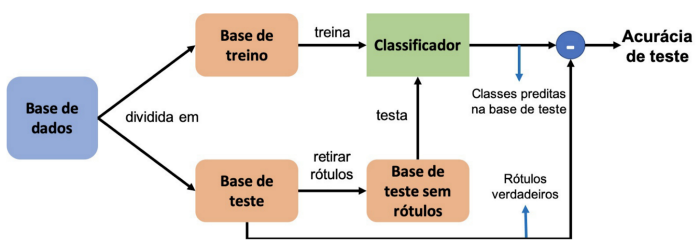

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

DT_SIN_PRI (Data primeiros sintomas) - Excluída por questão de desbalanceamento;
</br>
DT_NASC (Data Nascimento paciente) - Excluída por já possuir um atributo derivado IDADE;
</br>
ID_MUNICIP (ID do Município) - Excluída ser colinear com os ESTADOS;
</br>
ID_UNIDADE (ID Unidade de Saúde) - Excluída por ser colinear aos MUNICÍPIOS;
</br>
CLASSI_FIN (Classificação Final) - Excluída por se referir apenas aos casos de COVID-19;
</br>
SUPORT_VEN (SUPORTE VENTILATÓRIO) - Excluída por representar vazamento de informações ao algoritmo ML, pois obviamente quem usou suporte estava internado;
</br>
DATA_MES_ANO - Excluída por ser uma coluna intermediária para IDADE;
</br>
FAIXA_ETARIA - Excluída por ser uma coluna colinear a IDADE.

##4.1 - Pré-processamento

###Divisão entre PREVISORES e CLASSE

Com base nos em algumas características do paciente como IDADE, RAÇA, SINTOMAS, COMORBIDADES que são os (PREVISORES) desejo saber se o paciente foi INTERNADO EM UTI ou não (CLASSE) 

In [ ]:
# VERIFCA SE O PACIENTE POSSUI ALGUM SINTOMA, CASO POSITIVO (1), ELE É SINTOMATICO
srag.loc[srag.TOSSE == 1, 'SINTOMATICO'] = 1
srag.loc[srag.FEBRE == 1, 'SINTOMATICO'] = 1
srag.loc[srag.GARGANTA == 1, 'SINTOMATICO'] = 1
srag.loc[srag.DISPNEIA == 1, 'SINTOMATICO'] = 1
srag.loc[srag.DESC_RESP == 1, 'SINTOMATICO'] = 1
srag.loc[srag.SATURACAO == 1, 'SINTOMATICO'] = 1
srag.loc[srag.DIARREIA == 1, 'SINTOMATICO'] = 1
srag.loc[srag.VOMITO == 1, 'SINTOMATICO'] = 1
srag.loc[srag.DOR_ABD == 1, 'SINTOMATICO'] = 1
srag.loc[srag.PERD_OLFT == 1, 'SINTOMATICO'] = 1
srag.loc[srag.PERD_PALA == 1, 'SINTOMATICO'] = 1
srag.loc[srag.OUTRO_SIN == 1, 'SINTOMATICO'] = 1

srag.SINTOMATICO = srag.SINTOMATICO.fillna(2) # CASO NÃO TENHA SINTOMA (2), ELE É ASSINTOMÁTICO

# Exlusão de colunas
srag.drop(['SG_UF_NOT','DT_SIN_PRI','CS_ESCOL_N', 'DT_NASC', 'ID_MUNICIP', 'ID_UNIDADE', 
           'CLASSI_FIN', 'SUPORT_VEN', 'IDADE',
           'PUERPERA', 'CARDIOPATI', 'HEMATOLOGI', 'SIND_DOWN', 'HEPATICA', 'ASMA',
           'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI', 'IMUNODEPRE', 'RENAL',
           'OBESIDADE', 'OUT_MORBI','FEBRE', 'TOSSE',
           'GARGANTA', 'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIARREIA', 'VOMITO',
           'DOR_ABD', 'FADIGA', 'PERD_OLFT', 'PERD_PALA', 'OUTRO_SIN'], axis=1, inplace=True)

# ROTULA AS CLASSES 
srag.loc[srag.UTI == 1, 'UTI' ] = 'SIM'
srag.loc[srag.UTI == 2, 'UTI' ] = 'NAO'

srag.rename(columns={"UTI":"c#UTI"}, inplace = True)
srag = srag[['CS_SEXO', 'CS_RACA', 'CS_ZONA', 'SURTO_SG', 'FATOR_RISC', 'VACINA',
              'ANTIVIRAL', 'FAIXA_ETARIA', 'SINTOMATICO', 'c#UTI']]

#srag.to_csv('/content/drive/MyDrive/TCC PUC MINAS - MOISES FELIPE DOS SANTOS/DATASET/I - DADOS_PROCESSADOS/srag_am.csv', index=False, header=True)
srag.isnull().sum()

CS_SEXO         0
CS_RACA         0
CS_ZONA         0
SURTO_SG        0
FATOR_RISC      0
VACINA          0
ANTIVIRAL       0
FAIXA_ETARIA    0
SINTOMATICO     0
c#UTI           0
dtype: int64

###Seleção de Atributos

In [ ]:
srag = pd.read_csv('/content/drive/MyDrive/TCC PUC MINAS - MOISES FELIPE DOS SANTOS/DATASET/I - DADOS_PROCESSADOS/srag_am.csv')
srag.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28006 entries, 137 to 1084515
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CS_SEXO       28006 non-null  object 
 1   CS_RACA       28006 non-null  float64
 2   CS_ZONA       28006 non-null  float64
 3   SURTO_SG      28006 non-null  float64
 4   FATOR_RISC    28006 non-null  object 
 5   VACINA        28006 non-null  float64
 6   ANTIVIRAL     28006 non-null  float64
 7   FAIXA_ETARIA  28006 non-null  object 
 8   SINTOMATICO   28006 non-null  float64
 9   c#UTI         28006 non-null  object 
dtypes: float64(6), object(4)
memory usage: 3.6+ MB


In [ ]:
srag.head(5)

,CS_SEXO,CS_RACA,CS_ZONA,SURTO_SG,FATOR_RISC,VACINA,ANTIVIRAL,FAIXA_ETARIA,SINTOMATICO,c#UTI
137,M,1.0,1.0,1.0,S,1.0,1.0,>= 60,1.0,NAO
411,M,4.0,1.0,1.0,N,1.0,1.0,>= 60,1.0,NAO
418,M,4.0,1.0,1.0,S,2.0,1.0,>= 60,1.0,NAO
461,M,4.0,9.0,1.0,N,2.0,1.0,< 60,1.0,NAO
491,M,4.0,1.0,1.0,N,2.0,2.0,< 60,1.0,NAO


In [ ]:
np.unique(srag['c#UTI'], return_counts=True) # Verifico a divisão das classes {srag['UTI']}

(array(['NAO', 'SIM'], dtype=object), array([21423,  6583]))

In [ ]:
X_srag = srag.iloc[:,0:9].values # Extrai previsores
y_srag = srag.iloc[:,9].values # Extrai a CLASSE preditora
print('PREVISORES')
print(X_srag)
print('\nCLASSES')
print(y_srag)

#with open('/content/drive/MyDrive/TCC PUC MINAS - MOISES FELIPE DOS SANTOS/DATASET/I - DADOS_PROCESSADOS/previsores_classes.pkl', mode = 'wb') as f:
#  pickle.dump([X_srag, y_srag], f)

PREVISORES
[['M' 1.0 1.0 ... 1.0 '>= 60' 1.0]
 ['M' 4.0 1.0 ... 1.0 '>= 60' 1.0]
 ['M' 4.0 1.0 ... 1.0 '>= 60' 1.0]
 ...
 ['F' 5.0 1.0 ... 2.0 '< 60' 1.0]
 ['M' 4.0 1.0 ... 9.0 '>= 60' 1.0]
 ['M' 4.0 1.0 ... 9.0 '< 60' 1.0]]

CLASSES
['NAO' 'NAO' 'NAO' ... 'SIM' 'NAO' 'NAO']


###LabelEncoder

Nessa etapa, converterei os atributos categóricos em números para que os algoritmos machine learning possam ter um bom desempenho

In [ ]:
# Visualização dos dois únicos atributos categóricos: SEXO: CS_SEXO, FATOR RISCO: FATOR_RISC
srag.iloc[:,[0,4,7]].values 

array([['M', 'S', '>= 60'],
       ['M', 'N', '>= 60'],
       ['M', 'S', '>= 60'],
       ...,
       ['F', 'S', '< 60'],
       ['M', 'N', '>= 60'],
       ['M', 'N', '< 60']], dtype=object)

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder_teste = LabelEncoder()

# Converto os atributos categóricos em números
label_encoder_cs_sexo = LabelEncoder()
label_encoder_fator_risc = LabelEncoder()
label_encoder_faixa_etaria = LabelEncoder()

X_srag[:,0] = label_encoder_cs_sexo.fit_transform(X_srag[:,0])
X_srag[:,4] = label_encoder_fator_risc.fit_transform(X_srag[:,4])
X_srag[:,7] = label_encoder_faixa_etaria.fit_transform(X_srag[:,7])

# CS_SEXO       => [F]: 0,      [I]: 1,   [M]: 2
# FATOR_RISC    => [N]: 0,      [S]: 1
# FAIXA_ETARIA  => [< 60]: 0 ,  [>= 60]: 1

In [ ]:
print(X_srag[:,0])
print(X_srag[:,4])
print(X_srag[:,7])

[2 2 2 ... 0 2 2]
[1 0 1 ... 1 0 0]
[1 1 1 ... 0 1 0]


In [ ]:
#with open('/content/drive/MyDrive/TCC PUC MINAS - MOISES FELIPE DOS SANTOS/DATASET/I - DADOS_PROCESSADOS/x_srag_&_y_srag.pkl', mode = 'wb') as f:
#  pickle.dump([X_srag, y_srag], f)

In [ ]:
#with open('/content/drive/MyDrive/TCC PUC MINAS - MOISES FELIPE DOS SANTOS/DATASET/I - DADOS_PROCESSADOS/x_srag_&_y_srag.pkl','rb') as f:
#	X_srag, y_srag = pickle.load(f)

###OneHotEncoder

Após a conversão dos atributos catgóricos em números, será necessário garantiar a representatividade desses dados nos algoritmos, pois os mesmos usam operações tais como multiplicação, divisão etc e categorias identificadas como 0 e 1 por exemplo podem não ser considerados.

In [ ]:
 '''
 EXEMPLO DA COLUNA CS_SEXO
 
 F(FEMININO)  I(INDEFINIDO)  M(MASCULINO)
     0              1              2

 F(FEMININO)          1  0  0
 I(INDEFINIDO)        0  1  0
 M(MASCULINO)         0  0  1
 '''
print('Serão criadas mais ' + str( len(np.unique(srag['CS_SEXO'])) ) + ' colunas CS_SEXO')
print('Serão criadas mais ' + str( len(np.unique(srag['CS_RACA'])) ) + ' colunas CS_RACA')

Serão criadas mais 3 colunas CS_SEXO
Serão criadas mais 6 colunas CS_RACA


In [ ]:
print( np.unique(srag['CS_SEXO'], return_counts=True) )
print( np.unique(srag['CS_RACA'], return_counts=True) )
print( np.unique(srag['CS_ZONA'], return_counts=True) )

(array(['F', 'I', 'M'], dtype=object), array([12495,     1, 15510]))
(array([1., 2., 3., 4., 5., 9.]), array([ 1715,   326,   123, 23917,   557,  1368]))
(array([1., 2., 3., 9.]), array([24809,  1792,    58,  1347]))


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [ ]:
onehotencoder_srag = ColumnTransformer(transformers=[('OneHot', OneHotEncoder(), [0,1])], remainder='passthrough')
X_srag = onehotencoder_srag.fit_transform(X_srag)

In [ ]:
X_srag.shape

(28006, 16)

###Escalonamento dos valores

O escalonamento dos dados será realizado para colocar todos os valores na mesma faixa.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler_srag = StandardScaler()
X_srag = scaler_srag.fit_transform(X_srag) # Os dados estão na mesma faixa de valores

In [ ]:
#with open('/content/drive/MyDrive/TCC PUC MINAS - MOISES FELIPE DOS SANTOS/DATASET/I - DADOS_PROCESSADOS/srag_padronizadas.pkl', mode = 'wb') as f:
#  pickle.dump([X_srag, y_srag], f)

In [ ]:
with open('/content/drive/MyDrive/TCC PUC MINAS - MOISES FELIPE DOS SANTOS/DATASET/I - DADOS_PROCESSADOS/srag_padronizadas.pkl', mode = 'rb') as f:
  X_srag, y_srag = pickle.load(f)

###Divisão das base em TREINAMENTO e TESTE

In [ ]:
X_srag_treinamento, X_srag_teste, y_srag_treinamento, y_srag_teste = train_test_split(X_srag, y_srag, test_size = 0.2, random_state = 0, stratify=y_srag)

In [ ]:
# Dimensão das bases de Treinamentos
X_srag_treinamento.shape, y_srag_treinamento.shape 

((22404, 16), (22404,))

In [ ]:
# Dimensão das bases de Testes
X_srag_teste.shape, y_srag_teste.shape 

((5602, 16), (5602,))

####Salvas as bases particionadas

In [ ]:
# import pickle
#with open('/content/drive/MyDrive/TCC PUC MINAS - MOISES FELIPE DOS SANTOS/DATASET/I - DADOS_PROCESSADOS/srag_train_test_desbalance.pkl', mode = 'wb') as f:
#  pickle.dump([X_srag_treinamento, X_srag_teste, y_srag_treinamento, y_srag_teste], f)

####Lê as bases particionadas

In [ ]:
#with open('/content/drive/MyDrive/TCC PUC MINAS - MOISES FELIPE DOS SANTOS/DATASET/I - DADOS_PROCESSADOS/srag_train_test_desbalance.pkl','rb') as f:
#	X_srag_treinamento, X_srag_teste, y_srag_treinamento, y_srag_teste = pickle.load(f)

##4.2 - Balanceamento dos dados - sobreamostragem (Oversamplig - SMOTE)

In [ ]:
!pip install -U imbalanced-learn
!pip install imbalanced-learn==0.7.0

In [ ]:
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE
#smote = SMOTE(ratio='minority')
smote = SMOTE(sampling_strategy='minority')
X_over, y_over = smote.fit_resample(X_srag, y_srag)

In [ ]:
#with open('/content/drive/MyDrive/TCC PUC MINAS - MOISES FELIPE DOS SANTOS/DATASET/I - DADOS_PROCESSADOS/srag_balanceados.pkl', mode = 'wb') as f:
#  pickle.dump([X_over,y_over], f)

In [ ]:
with open('/content/drive/MyDrive/TCC PUC MINAS - MOISES FELIPE DOS SANTOS/DATASET/I - DADOS_PROCESSADOS/srag_balanceados.pkl', mode = 'rb') as f:
  X_over,y_over = pickle.load(f)

In [ ]:
X_srag.shape, y_srag.shape

((28006, 16), (28006,))

In [ ]:
X_over.shape, y_over.shape 

((42846, 16), (42846,))

In [ ]:
X_srag_treinamento_balance, X_srag_teste_balance, y_srag_treinamento_balance, y_srag_teste_balance = train_test_split(X_over, y_over, test_size = 0.15, random_state = 0, stratify=y_over)

In [ ]:
# Dimensão das bases de Treinamentos
X_srag_treinamento_balance.shape, y_srag_treinamento_balance.shape 

((36419, 16), (36419,))

####Salvar conjunto balanceado 

In [ ]:
#with open('/content/drive/MyDrive/TCC PUC MINAS - MOISES FELIPE DOS SANTOS/DATASET/I - DADOS_PROCESSADOS/srag_train_test_balance.pkl', mode = 'wb') as f:
#  pickle.dump([X_srag_treinamento_balance, X_srag_teste_balance, y_srag_treinamento_balance, y_srag_teste_balance], f)

####Lendo conjunto balanceado 

In [ ]:
with open('/content/drive/MyDrive/TCC PUC MINAS - MOISES FELIPE DOS SANTOS/DATASET/I - DADOS_PROCESSADOS/srag_train_test_balance.pkl','rb') as f:
	X_srag_treinamento_balance, X_srag_teste_balance, y_srag_treinamento_balance, y_srag_teste_balance = pickle.load(f)

In [ ]:
# Dimensão das bases de Treinamentos
X_srag_treinamento_balance.shape, y_srag_treinamento_balance.shape

((36419, 16), (36419,))

In [ ]:
# Dimensão das bases de Testes
X_srag_teste_balance.shape, y_srag_teste_balance.shape

((6427, 16), (6427,))